# Unsupervised Learning Trading Strategy

* Download/Load SP500 stocks prices data.
* Calculate different features and indicators on each stock.
* Aggregate on monthly level and filter top 150 most liquid stocks.
* Calculate Monthly Returns for different time-horizons.
* Download Fama-French Factors and Calculate Rolling Factor Betas.
* For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.
* For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization.
* Visualize Portfolio returns and compare to SP500 returns.

In [5]:
pip install pandas numpy matplotlib statsmodels pandas_datareader datetime yfinance scikit-learn PyPortfolioOpt pandas_ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 7.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.8/247.8 kB 6.7 MB/s eta 0:00:00
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218907 sha256=1b31aa00f12a62d9408f2ead8522a58c56d7325274382082cabfb286c1583d81
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta


###1. Download/Load SP500 stocks prices data.

In [6]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings('ignore')

sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')

symbols_list = sp500['Symbol'].unique().tolist()

end_date = '2024-06-30'

start_date = pd.to_datetime(end_date)-pd.DateOffset(365*8)

df = yf.download(tickers=symbols_list,
                 start=start_date,
                 end=end_date).stack()

df.index.names = ['date', 'ticker']

df.columns = df.columns.str.lower()

df

[*********************100%%**********************]  503 of 503 completed


Price               adj close       close        high         low        open  \
date       ticker                                                               
2016-07-05 A        41.162395   43.750000   44.349998   43.630001   44.310001   
           AAL      27.802402   28.930000   29.160000   28.190001   29.090000   
           AAPL     21.811764   23.747499   23.850000   23.615000   23.847500   
           ABBV     43.881748   61.919998   62.709999   61.770000   62.500000   
           ABT      34.040817   39.439999   39.560001   39.209999   39.310001   
...                       ...         ...         ...         ...         ...   
2024-06-28 XYL     135.630005  135.630005  137.990005  134.300003  136.639999   
           YUM     132.460007  132.460007  132.990005  131.720001  132.509995   
           ZBH     108.529999  108.529999  109.580002  107.379997  108.550003   
           ZBRA    308.929993  308.929993  314.040009  306.160004  309.000000   
           ZTS     173.360001  173.360001  177.070007  173.029999  176.460007   

Price                   volume  
date       ticker               
2016-07-05 A         1813500.0  
           AAL       9467000.0  
           AAPL    110820800.0  
           ABBV      6293600.0  
           ABT      10029300.0  
...                        ...  
2024-06-28 XYL       2197600.0  
           YUM       5819000.0  
           ZBH       2774600.0  
           ZBRA       417900.0  
           ZTS       4189600.0  

[991324 rows x 6 columns]

## 2. Calculate features and technical indicators for each stock.

* Garman-Klass Volatility
* RSI
* Bollinger Bands
* ATR
* MACD
* Dollar Volume

\begin{equation}
\text{Garman-Klass Volatility} = \frac{(\ln(\text{High}) - \ln(\text{Low}))^2}{2} - (2\ln(2) - 1)(\ln(\text{Adj Close}) - \ln(\text{Open}))^2
\end{equation}

In [7]:
df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)

df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])

df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])

df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'],
                        low=stock_data['low'],
                        close=stock_data['close'],
                        length=14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)

df['dollar_volume'] = (df['adj close']*df['volume'])/1e6

In [8]:
df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2016-07-05 A        41.162395   43.750000   44.349998   43.630001   44.310001   
           AAL      27.802402   28.930000   29.160000   28.190001   29.090000   
           AAPL     21.811764   23.747499   23.850000   23.615000   23.847500   
           ABBV     43.881748   61.919998   62.709999   61.770000   62.500000   
           ABT      34.040817   39.439999   39.560001   39.209999   39.310001   
...                       ...         ...         ...         ...         ...   
2024-06-28 XYL     135.630005  135.630005  137.990005  134.300003  136.639999   
           YUM     132.460007  132.460007  132.990005  131.720001  132.509995   
           ZBH     108.529999  108.529999  109.580002  107.379997  108.550003   
           ZBRA    308.929993  308.929993  314.040009  306.160004  309.000000   
           ZTS     173.360001  173.360001  177.070007  173.029999  176.460007   

Price                   volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2016-07-05 A         1813500.0         -0.001963        NaN       NaN   
           AAL       9467000.0         -0.000219        NaN       NaN   
           AAPL    110820800.0         -0.003027        NaN       NaN   
           ABBV      6293600.0         -0.048204        NaN       NaN   
           ABT      10029300.0         -0.007962        NaN       NaN   
...                        ...               ...        ...       ...   
2024-06-28 XYL       2197600.0          0.000346  45.676162  4.915082   
           YUM       5819000.0          0.000046  39.819102  4.880761   
           ZBH       2774600.0          0.000206  35.442075  4.654188   
           ZBRA       417900.0          0.000323  52.479117  5.693582   
           ZTS       4189600.0          0.000145  52.980608  5.120666   

Price                bb_mid   bb_high       atr      macd  dollar_volume  
date       ticker                                                         
2016-07-05 A            NaN       NaN       NaN       NaN      74.648004  
           AAL          NaN       NaN       NaN       NaN     263.205344  
           AAPL         NaN       NaN       NaN       NaN    2417.197110  
           ABBV         NaN       NaN       NaN       NaN     276.174170  
           ABT          NaN       NaN       NaN       NaN     341.405569  
...                     ...       ...       ...       ...            ...  
2024-06-28 XYL     4.937657  4.960231  0.658201 -0.523446     298.060499  
           YUM     4.923641  4.966522  0.158722 -1.244392     770.784779  
           ZBH     4.704769  4.755350 -0.774960 -1.010072     301.127335  
           ZBRA    5.721439  5.749296 -0.248949 -0.249066     129.101844  
           ZTS     5.158528  5.196390  0.967429  0.072096     726.309059  

[991324 rows x 14 columns]

##3. Aggregate to monthly level and filter top 150 most liquid stocks for each month

* To reduce training time and experiment with features and strategies, we convert the business daily data to monthly-end frequency.

In [9]:
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open',
                                                          'high', 'low', 'close']]

data = pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
           df.unstack()[last_cols].resample('M').last().stack('ticker')],
          axis=1).dropna()

data

dollar_volume   adj close       atr   bb_high    bb_low  \
date       ticker                                                            
2016-08-31 A           87.824764   44.201351 -1.367656  3.844183  3.800905   
           AAL        269.710252   34.989559  0.010620  3.624501  3.511263   
           AAPL      2718.975490   24.494831 -1.321606  3.275645  3.235305   
           ABBV       309.214758   45.825451 -1.510144  3.908017  3.843967   
           ABT        377.320476   36.491032 -1.194762  3.715369  3.629980   
...                          ...         ...       ...       ...       ...   
2024-06-30 XYL        162.936754  135.630005  0.658201  4.960231  4.915082   
           YUM        294.358707  132.460007  0.158722  4.966522  4.880761   
           ZBH        197.415924  108.529999 -0.774960  4.755350  4.654188   
           ZBRA        90.195482  308.929993 -0.248949  5.749296  5.693582   
           ZTS        433.526981  173.360001  0.967429  5.196390  5.120666   

                     bb_mid  garman_klass_vol      macd        rsi  
date       ticker                                                   
2016-08-31 A       3.822544         -0.001547 -0.110174  50.780877  
           AAL     3.567882         -0.000479  0.859347  59.063214  
           AAPL    3.255475         -0.002162 -0.117384  57.326597  
           ABBV    3.875992         -0.043844 -0.274591  42.552702  
           ABT     3.672675         -0.009720 -0.267446  38.739599  
...                     ...               ...       ...        ...  
2024-06-30 XYL     4.937657          0.000346 -0.523446  45.676162  
           YUM     4.923641          0.000046 -1.244392  39.819102  
           ZBH     4.704769          0.000206 -1.010072  35.442075  
           ZBRA    5.721439          0.000323 -0.249066  52.479117  
           ZTS     5.158528          0.000145  0.072096  52.980608  

[46849 rows x 9 columns]

Calculate 5-year rolling averages of dollar volume for each stocks before filtering.

In [10]:
data['dollar_volume'] = (data.loc[:, 'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())

data['dollar_vol_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending=False))

data = data[data['dollar_vol_rank']<150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)

data

adj close       atr   bb_high    bb_low    bb_mid  \
date       ticker                                                       
2017-07-31 AAL      48.955444  0.799138  3.990058  3.892343  3.941200   
           AAPL     34.805634 -1.150805  3.616847  3.533293  3.575070   
           ABBV     51.918213 -1.278378  4.031401  3.968483  3.999942   
           ABT      43.763519 -1.325561  3.843769  3.759048  3.801408   
           ACN     115.969185 -1.247596  4.777047  4.711845  4.744446   
...                       ...       ...       ...       ...       ...   
2024-06-30 VZ       41.240002 -0.606494  3.759060  3.698619  3.728839   
           WFC      59.389999  0.369039  4.110066  4.051801  4.080934   
           WMT      67.709999  1.258892  4.245980  4.197531  4.221755   
           XOM     115.120003  0.457795  4.772566  4.692969  4.732767   
           ZTS     173.360001  0.967429  5.196390  5.120666  5.158528   

                   garman_klass_vol      macd        rsi  
date       ticker                                         
2017-07-31 AAL            -0.000281  0.299014  49.738383  
           AAPL           -0.002001 -0.177617  50.672313  
           ABBV           -0.036168 -0.110441  45.182802  
           ABT            -0.005979  0.292508  55.959202  
           ACN            -0.004038  0.093003  60.835427  
...                             ...       ...        ...  
2024-06-30 VZ              0.000201  0.438589  57.417661  
           WFC             0.000079 -0.447230  53.367651  
           WMT             0.000064  1.953787  61.898824  
           XOM             0.000114 -0.324234  53.431096  
           ZTS             0.000145  0.072096  52.980608  

[12516 rows x 8 columns]

## 4. Calculate Monthly Returns for different time horizons as features.

* To capture time series dynamics that reflect, for example, momentum patterns, we compute historical returns using the method .pct_change(lag), that is, returns over various monthly periods as identified by lags.

In [11]:
def calculate_returns(df):

  outlier_cutoff = 0.005

  lags = [1, 2, 3, 6, 9, 12]

  for lag in lags:

    df[f'return_{lag}m'] = (df['adj close']
                            .pct_change(lag)
                            .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                   upper=x.quantile(1-outlier_cutoff)))
                            .add(1)
                            .pow(1/lag)
                            .sub(1))

  return df

data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()

data

adj close       atr   bb_high    bb_low    bb_mid  \
date       ticker                                                       
2018-07-31 AAL      38.702709  0.794336  3.699472  3.591909  3.645691   
           AAPL     45.223682 -1.073866  3.860463  3.808181  3.834322   
           ABBV     70.902924  0.047627  4.341630  4.234662  4.288146   
           ABT      59.436672 -0.940371  4.114918  4.021121  4.068020   
           ACN     146.102783 -0.835028  5.058385  4.997519  5.027952   
...                       ...       ...       ...       ...       ...   
2024-06-30 VRTX    468.720001  1.313968  6.194524  6.135570  6.165047   
           VZ       41.240002 -0.606494  3.759060  3.698619  3.728839   
           WFC      59.389999  0.369039  4.110066  4.051801  4.080934   
           WMT      67.709999  1.258892  4.245980  4.197531  4.221755   
           XOM     115.120003  0.457795  4.772566  4.692969  4.732767   

                   garman_klass_vol      macd        rsi  return_1m  \
date       ticker                                                     
2018-07-31 AAL             0.000092 -0.297513  49.117687   0.041623   
           AAPL           -0.000885 -0.163311  52.605230   0.027983   
           ABBV           -0.025348 -0.726975  45.920927   0.005633   
           ABT            -0.003467  0.529881  62.882447   0.079433   
           ACN            -0.003209 -0.172550  42.887954  -0.026040   
...                             ...       ...        ...        ...   
2024-06-30 VRTX            0.000173  1.432555  57.870674   0.029385   
           VZ              0.000201  0.438589  57.417661   0.002187   
           WFC             0.000079 -0.447230  53.367651  -0.008845   
           WMT             0.000064  1.953787  61.898824   0.029653   
           XOM             0.000114 -0.324234  53.431096  -0.018250   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2018-07-31 AAL     -0.047041  -0.026289  -0.050880  -0.017899   -0.019393  
           AAPL     0.009109   0.049478   0.022909   0.014540    0.022060  
           ABBV    -0.029587  -0.011801  -0.028860   0.005494    0.026310  
           ABT      0.034389   0.042361   0.010427   0.022867    0.025837  
           ACN      0.011460   0.017611   0.000037   0.013581    0.019435  
...                      ...        ...        ...        ...         ...  
2024-06-30 VRTX     0.092359   0.038904   0.023857   0.033729    0.024173  
           VZ       0.021917  -0.000415   0.020633   0.032199    0.014692  
           WFC      0.003462   0.010086   0.033991   0.044934    0.030437  
           WMT      0.069957   0.041337   0.044342   0.028130    0.022803  
           XOM     -0.009408  -0.000531   0.026742   0.000589    0.008824  

[10365 rows x 14 columns]

## 5. Download Fama-French Factors and Calculate Rolling Factor Betas.

* We will introduce the Fama—French data to estimate the exposure of assets to common risk factors using linear regression.

* The five Fama—French factors, namely market risk, size, value, operating profitability, and investment have been shown empirically to explain asset returns and are commonly used to assess the risk/return profile of portfolios. Hence, it is natural to include past factor exposures as financial features in models.

* We can access the historical factor returns using the pandas-datareader and estimate historical exposures using the RollingOLS rolling linear regression.

In [15]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
                             'famafrench',
                             start='2010')[0].drop('RF', axis=1)

factor_data.index = factor_data.index.to_timestamp()

factor_data = factor_data.resample('M').last().div(100)

factor_data.index.name = 'date'

factor_data = factor_data.join(data['return_1m']).sort_index()

factor_data


Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2018-07-31 AAL     0.0319 -0.0193  0.0047  0.0156  0.0035   0.041623
           AAPL    0.0319 -0.0193  0.0047  0.0156  0.0035   0.027983
           ABBV    0.0319 -0.0193  0.0047  0.0156  0.0035   0.005633
           ABT     0.0319 -0.0193  0.0047  0.0156  0.0035   0.079433
           ACN     0.0319 -0.0193  0.0047  0.0156  0.0035  -0.026040
...                   ...     ...     ...     ...     ...        ...
2024-05-31 VRTX    0.0434  0.0059 -0.0133  0.0321 -0.0287   0.159186
           VZ      0.0434  0.0059 -0.0133  0.0321 -0.0287   0.042036
           WFC     0.0434  0.0059 -0.0133  0.0321 -0.0287   0.015922
           WMT     0.0434  0.0059 -0.0133  0.0321 -0.0287   0.111839
           XOM     0.0434  0.0059 -0.0133  0.0321 -0.0287  -0.000487

[10223 rows x 6 columns]

*Filter out stocks with less than 10 months of data

In [19]:
observations = factor_data.groupby(level=1).size()

valid_stocks = observations[observations >=10 ]

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2018-07-31 AAL     0.0319 -0.0193  0.0047  0.0156  0.0035   0.041623
           AAPL    0.0319 -0.0193  0.0047  0.0156  0.0035   0.027983
           ABBV    0.0319 -0.0193  0.0047  0.0156  0.0035   0.005633
           ABT     0.0319 -0.0193  0.0047  0.0156  0.0035   0.079433
           ACN     0.0319 -0.0193  0.0047  0.0156  0.0035  -0.026040
...                   ...     ...     ...     ...     ...        ...
2024-05-31 VRTX    0.0434  0.0059 -0.0133  0.0321 -0.0287   0.159186
           VZ      0.0434  0.0059 -0.0133  0.0321 -0.0287   0.042036
           WFC     0.0434  0.0059 -0.0133  0.0321 -0.0287   0.015922
           WMT     0.0434  0.0059 -0.0133  0.0321 -0.0287   0.111839
           XOM     0.0434  0.0059 -0.0133  0.0321 -0.0287  -0.000487

[10181 rows x 6 columns]

* Calculate Rolling Factors Beta

In [22]:
betas = (factor_data.groupby(level=1,
                            group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'],
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params
         .drop('const', axis=1)))
betas

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2018-07-31 AAL          NaN       NaN       NaN       NaN       NaN
           AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2024-05-31 VRTX    0.392347  0.763705 -0.574362  0.647316  0.505625
           VZ      0.484211 -0.865594  0.243962  0.220277  0.058509
           WFC     1.081661  0.184096  1.299962 -0.616455 -0.772449
           WMT     0.573129 -0.030582  0.000610  0.770719 -0.001395
           XOM     0.797858 -0.087120  0.436570  0.739915  0.542975

[10181 rows x 5 columns]

In [27]:
factors = ['Mkt-RF','SMB','HML','RMW','CMA']
#data = (data.join(betas.groupby('ticker').shift()))

data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

data = data.drop('adj close', axis=1)
data = data.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10170 entries, (Timestamp('2018-07-31 00:00:00'), 'AAL') to (Timestamp('2024-06-30 00:00:00'), 'XOM')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   atr               10170 non-null  float64
 1   bb_high           10170 non-null  float64
 2   bb_low            10170 non-null  float64
 3   bb_mid            10170 non-null  float64
 4   garman_klass_vol  10170 non-null  float64
 5   macd              10170 non-null  float64
 6   rsi               10170 non-null  float64
 7   return_1m         10170 non-null  float64
 8   return_2m         10170 non-null  float64
 9   return_3m         10170 non-null  float64
 10  return_6m         10170 non-null  float64
 11  return_9m         10170 non-null  float64
 12  return_12m        10170 non-null  float64
 13  Mkt-RF            10170 non-null  float64
 14  SMB               10170 non-null  float64
 15  HML        

In [24]:
data

adj close       atr   bb_high    bb_low    bb_mid  \
date       ticker                                                       
2018-07-31 AAL      38.702709  0.794336  3.699472  3.591909  3.645691   
           AAPL     45.223682 -1.073866  3.860463  3.808181  3.834322   
           ABBV     70.902924  0.047627  4.341630  4.234662  4.288146   
           ABT      59.436672 -0.940371  4.114918  4.021121  4.068020   
           ACN     146.102783 -0.835028  5.058385  4.997519  5.027952   
...                       ...       ...       ...       ...       ...   
2024-06-30 VRTX    468.720001  1.313968  6.194524  6.135570  6.165047   
           VZ       41.240002 -0.606494  3.759060  3.698619  3.728839   
           WFC      59.389999  0.369039  4.110066  4.051801  4.080934   
           WMT      67.709999  1.258892  4.245980  4.197531  4.221755   
           XOM     115.120003  0.457795  4.772566  4.692969  4.732767   

                   garman_klass_vol      macd        rsi  return_1m  \
date       ticker                                                     
2018-07-31 AAL             0.000092 -0.297513  49.117687   0.041623   
           AAPL           -0.000885 -0.163311  52.605230   0.027983   
           ABBV           -0.025348 -0.726975  45.920927   0.005633   
           ABT            -0.003467  0.529881  62.882447   0.079433   
           ACN            -0.003209 -0.172550  42.887954  -0.026040   
...                             ...       ...        ...        ...   
2024-06-30 VRTX            0.000173  1.432555  57.870674   0.029385   
           VZ              0.000201  0.438589  57.417661   0.002187   
           WFC             0.000079 -0.447230  53.367651  -0.008845   
           WMT             0.000064  1.953787  61.898824   0.029653   
           XOM             0.000114 -0.324234  53.431096  -0.018250   

                   return_2m  return_3m  return_6m  return_9m  return_12m  \
date       ticker                                                           
2018-07-31 AAL     -0.047041  -0.026289  -0.050880  -0.017899   -0.019393   
           AAPL     0.009109   0.049478   0.022909   0.014540    0.022060   
           ABBV    -0.029587  -0.011801  -0.028860   0.005494    0.026310   
           ABT      0.034389   0.042361   0.010427   0.022867    0.025837   
           ACN      0.011460   0.017611   0.000037   0.013581    0.019435   
...                      ...        ...        ...        ...         ...   
2024-06-30 VRTX     0.092359   0.038904   0.023857   0.033729    0.024173   
           VZ       0.021917  -0.000415   0.020633   0.032199    0.014692   
           WFC      0.003462   0.010086   0.033991   0.044934    0.030437   
           WMT      0.069957   0.041337   0.044342   0.028130    0.022803   
           XOM     -0.009408  -0.000531   0.026742   0.000589    0.008824   

                   Mkt-RF  SMB  HML  RMW  CMA  
date       ticker                              
2018-07-31 AAL        NaN  NaN  NaN  NaN  NaN  
           AAPL       NaN  NaN  NaN  NaN  NaN  
           ABBV       NaN  NaN  NaN  NaN  NaN  
           ABT        NaN  NaN  NaN  NaN  NaN  
           ACN        NaN  NaN  NaN  NaN  NaN  
...                   ...  ...  ...  ...  ...  
2024-06-30 VRTX       NaN  NaN  NaN  NaN  NaN  
           VZ         NaN  NaN  NaN  NaN  NaN  
           WFC        NaN  NaN  NaN  NaN  NaN  
           WMT        NaN  NaN  NaN  NaN  NaN  
           XOM        NaN  NaN  NaN  NaN  NaN  

[10365 rows x 19 columns]

## 6. For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.

### K-Means Clustering
* You may want to initialize predefined centroids for each cluster based on your research.

* For visualization purpose of this tutorial we will initially rely on the ‘k-means++’ initialization.

* Then we will pre-define our centroids for each cluster.

In [29]:
from sklearn.cluster import KMeans

data = data.drop('cluster', axis=1)
def get_clusters(df):
  df['cluster'] = KMeans(n_clusters=4,
                         random_state=0,
                         init=intial_centroids).fit(df).labels_
  return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

data

atr   bb_high    bb_low    bb_mid  garman_klass_vol  \
date       ticker                                                             
2018-07-31 AAL     0.794336  3.699472  3.591909  3.645691          0.000092   
           AAPL   -1.073866  3.860463  3.808181  3.834322         -0.000885   
           ABBV    0.047627  4.341630  4.234662  4.288146         -0.025348   
           ABT    -0.940371  4.114918  4.021121  4.068020         -0.003467   
           ACN    -0.835028  5.058385  4.997519  5.027952         -0.003209   
...                     ...       ...       ...       ...               ...   
2024-06-30 VRTX    1.313968  6.194524  6.135570  6.165047          0.000173   
           VZ     -0.606494  3.759060  3.698619  3.728839          0.000201   
           WFC     0.369039  4.110066  4.051801  4.080934          0.000079   
           WMT     1.258892  4.245980  4.197531  4.221755          0.000064   
           XOM     0.457795  4.772566  4.692969  4.732767          0.000114   

                       macd        rsi  return_1m  return_2m  return_3m  \
date       ticker                                                         
2018-07-31 AAL    -0.297513  49.117687   0.041623  -0.047041  -0.026289   
           AAPL   -0.163311  52.605230   0.027983   0.009109   0.049478   
           ABBV   -0.726975  45.920927   0.005633  -0.029587  -0.011801   
           ABT     0.529881  62.882447   0.079433   0.034389   0.042361   
           ACN    -0.172550  42.887954  -0.026040   0.011460   0.017611   
...                     ...        ...        ...        ...        ...   
2024-06-30 VRTX    1.432555  57.870674   0.029385   0.092359   0.038904   
           VZ      0.438589  57.417661   0.002187   0.021917  -0.000415   
           WFC    -0.447230  53.367651  -0.008845   0.003462   0.010086   
           WMT     1.953787  61.898824   0.029653   0.069957   0.041337   
           XOM    -0.324234  53.431096  -0.018250  -0.009408  -0.000531   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2018-07-31 AAL     -0.050880  -0.017899   -0.019393  1.202496  1.530517   
           AAPL     0.022909   0.014540    0.022060  1.318268 -0.329260   
           ABBV    -0.028860   0.005494    0.026310  0.477782  0.507645   
           ABT      0.010427   0.022867    0.025837  0.787255 -0.128957   
           ACN      0.000037   0.013581    0.019435  1.213839 -0.190147   
...                      ...        ...         ...       ...       ...   
2024-06-30 VRTX     0.023857   0.033729    0.024173  0.509512  0.091933   
           VZ       0.020633   0.032199    0.014692  0.468973 -0.455689   
           WFC      0.033991   0.044934    0.030437  1.088353 -0.098942   
           WMT      0.044342   0.028130    0.022803  0.616885 -0.391019   
           XOM      0.026742   0.000589    0.008824  1.069147  0.144807   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2018-07-31 AAL     0.397559  0.197123  0.823948        0  
           AAPL   -0.628205  0.427703  0.622943        1  
           ABBV   -0.202965  0.535353  0.469552        0  
           ABT    -0.439399  0.243872  0.934529        2  
           ACN    -0.253472  0.340847  0.082172        0  
...                     ...       ...       ...      ...  
2024-06-30 VRTX   -0.891581  0.067606  0.854369        0  
           VZ      0.229425  0.187526  0.226230        0  
           WFC     1.567178 -0.738443 -0.867935        0  
           WMT    -0.373268  0.212561  0.684859        1  
           XOM     0.843598 -0.485055  0.434796        0  

[10170 rows x 19 columns]

In [30]:
def plot_clusters(data):

    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]

    plt.scatter(cluster_0.iloc[:,0] , cluster_0.iloc[:,6] , color = 'red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,0] , cluster_1.iloc[:,6] , color = 'green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,0] , cluster_2.iloc[:,6] , color = 'blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,0] , cluster_3.iloc[:,6] , color = 'black', label='cluster 3')

    plt.legend()
    plt.show()
    return

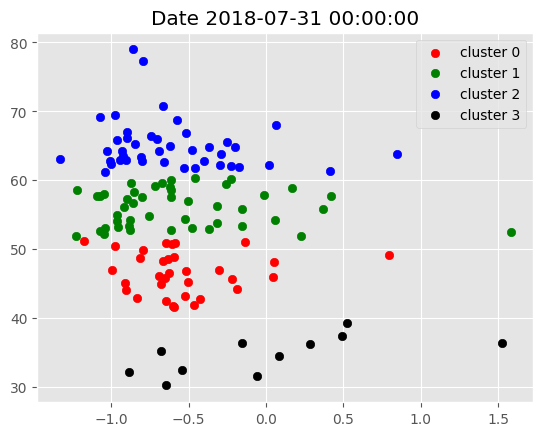

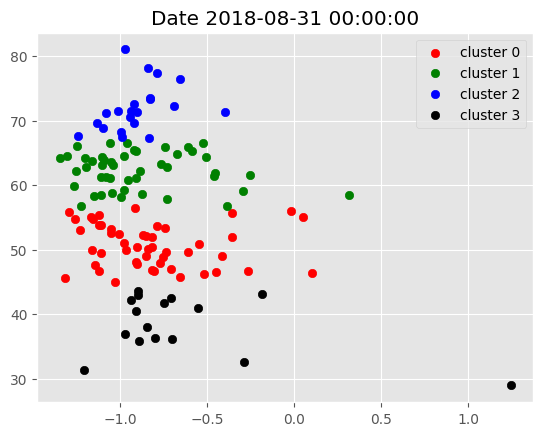

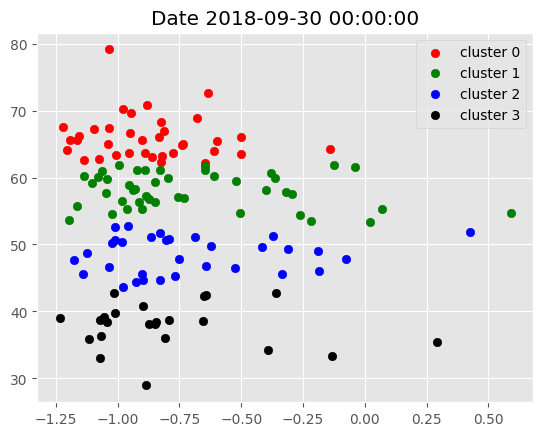

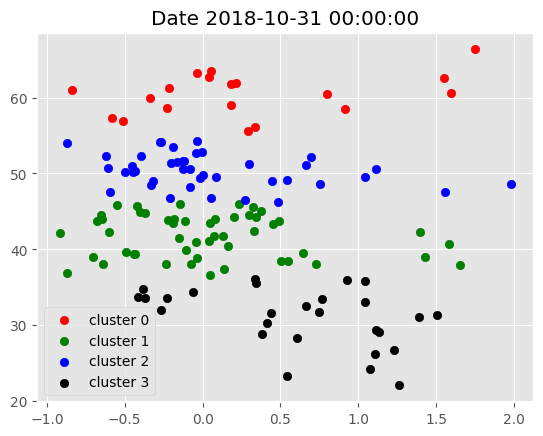

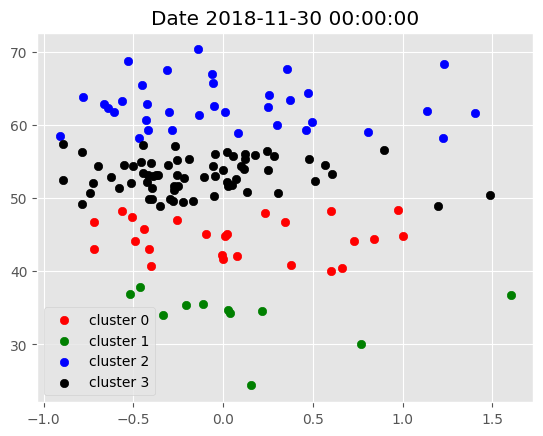

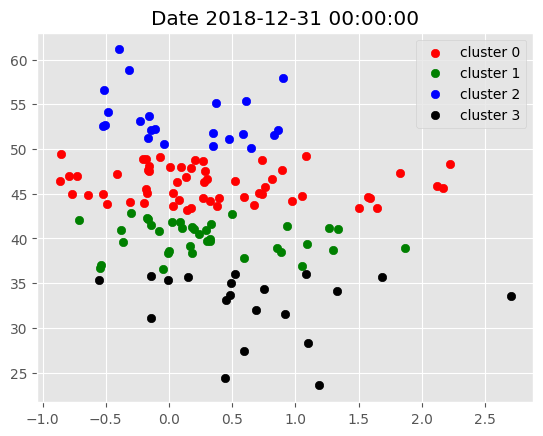

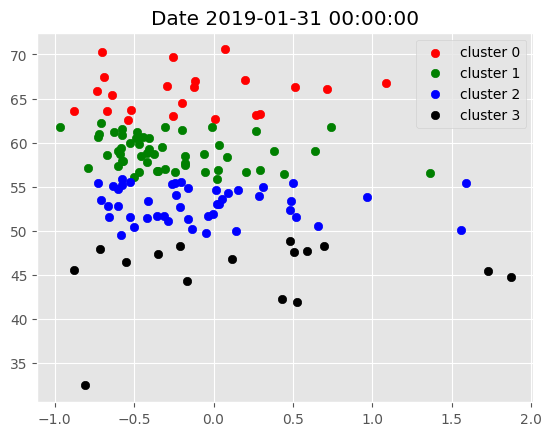

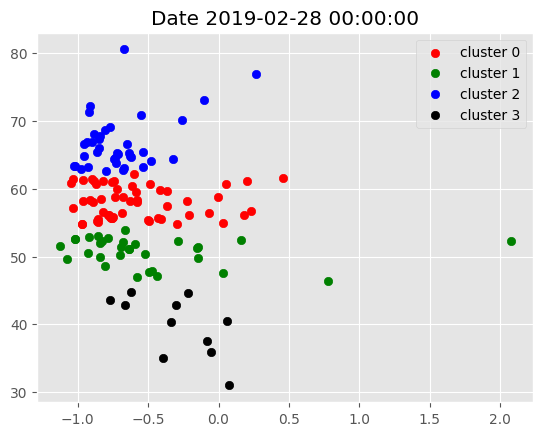

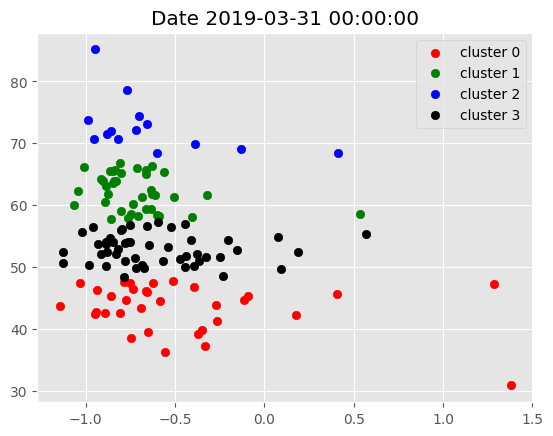

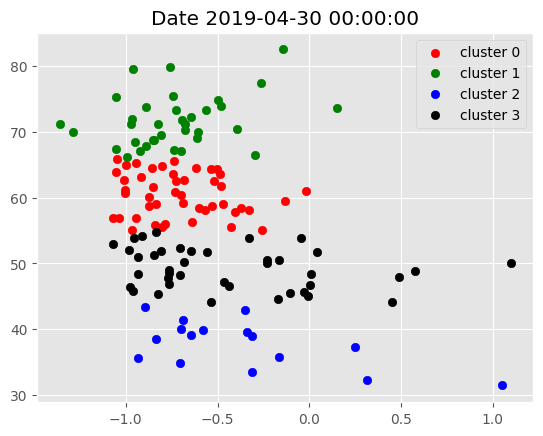

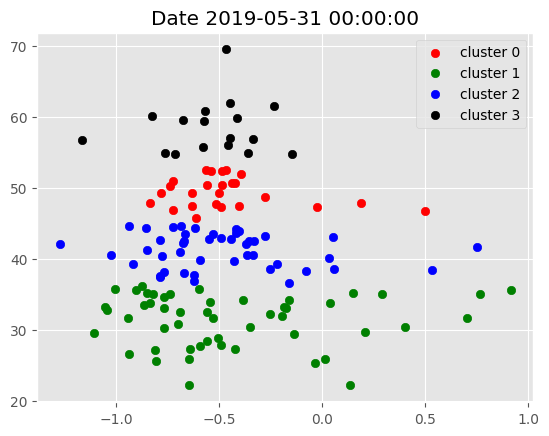

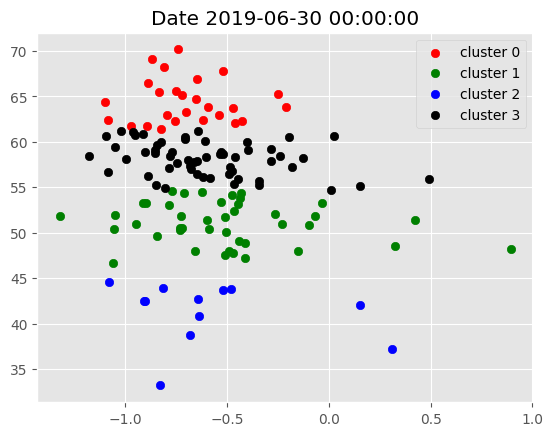

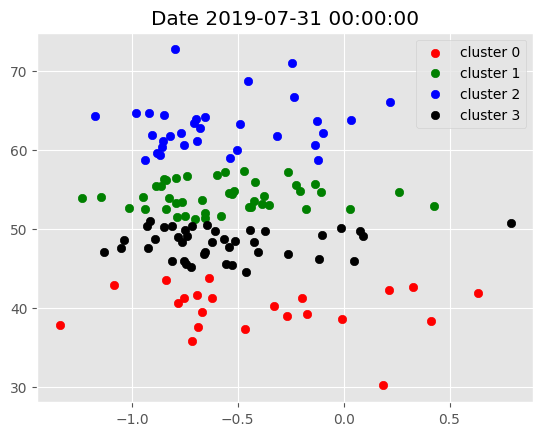

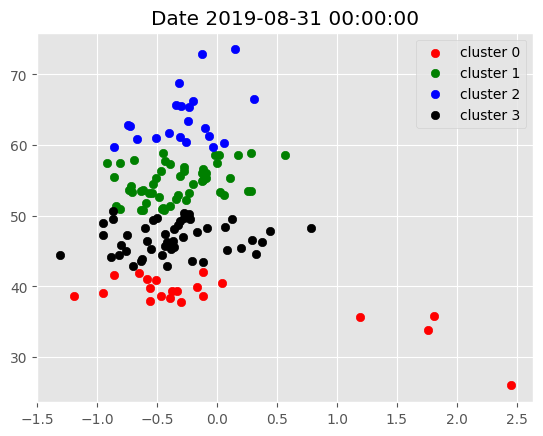

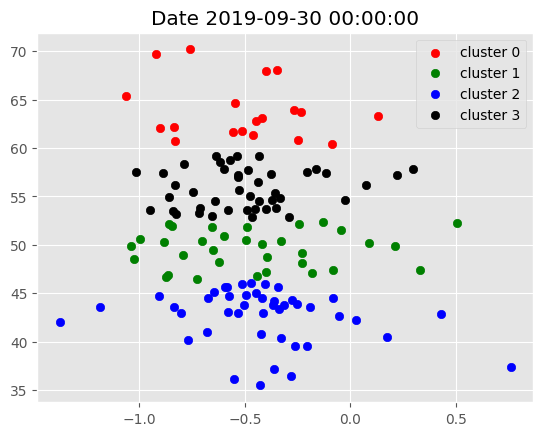

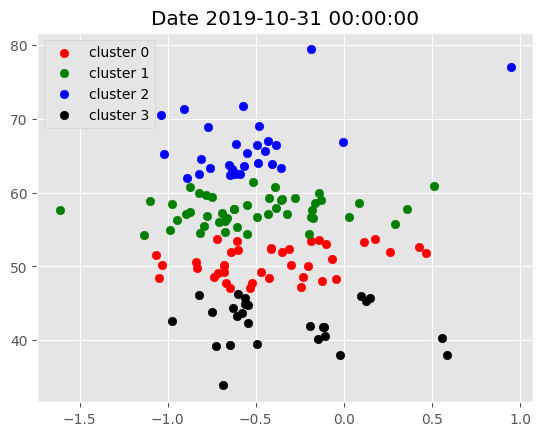

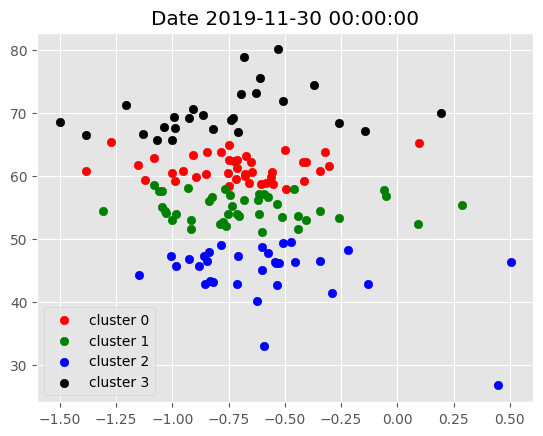

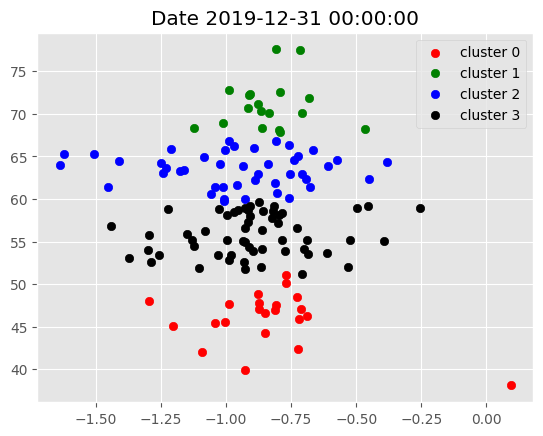

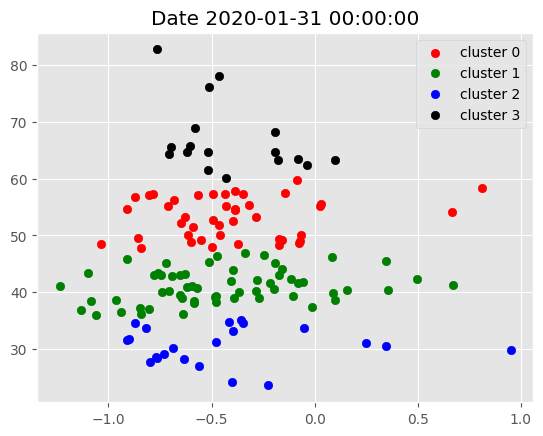

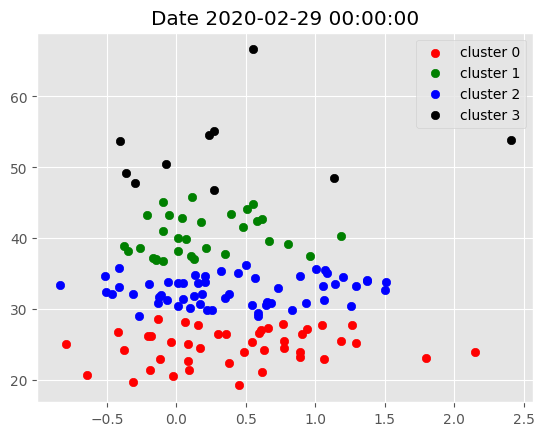

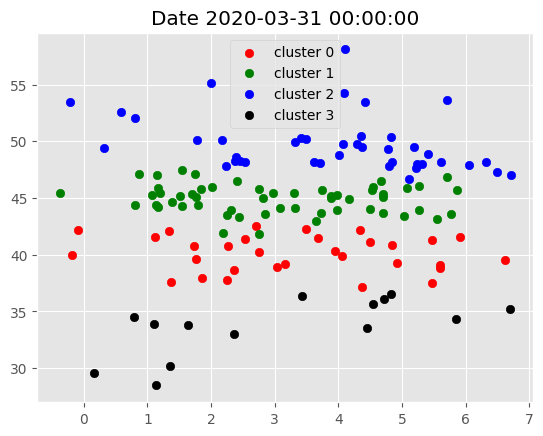

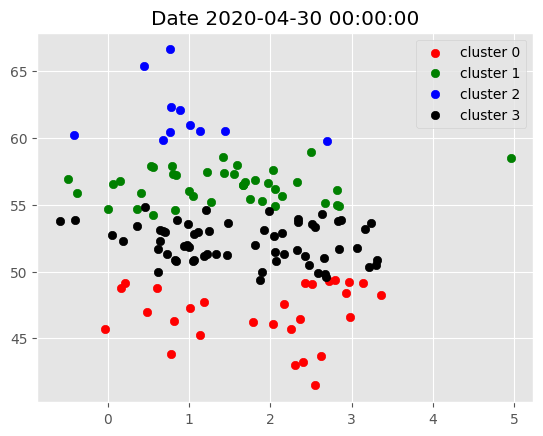

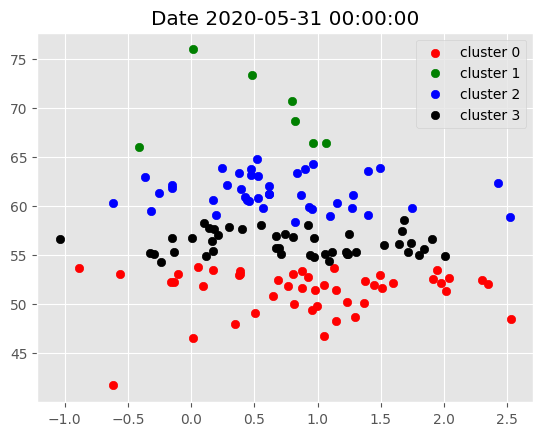

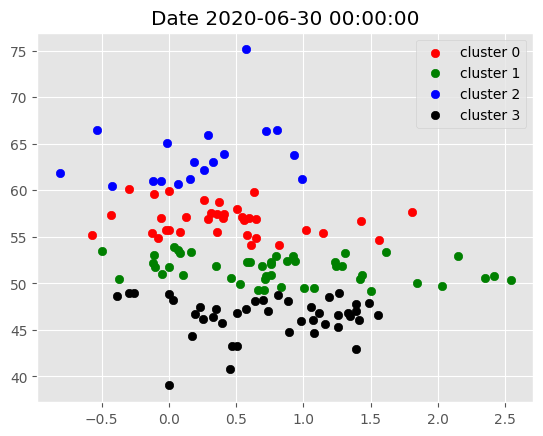

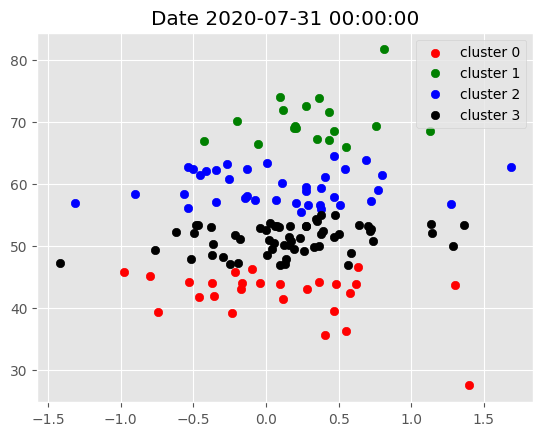

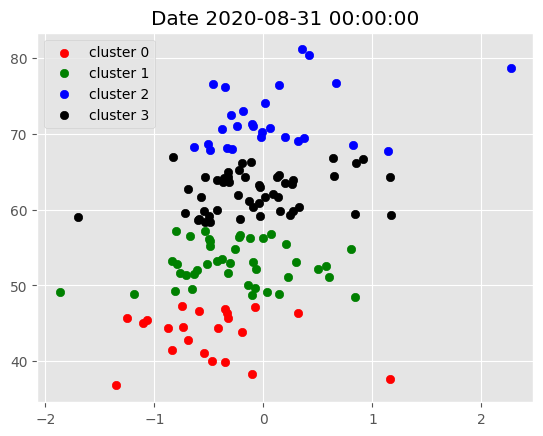

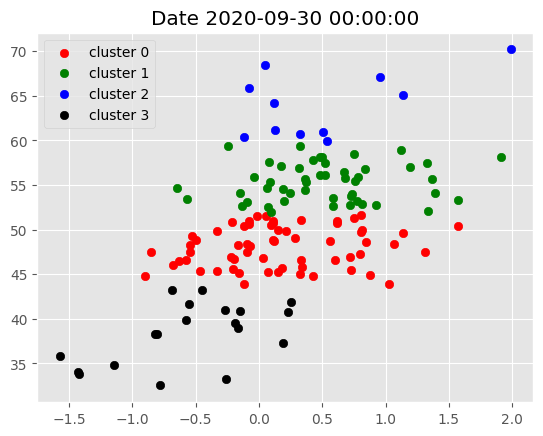

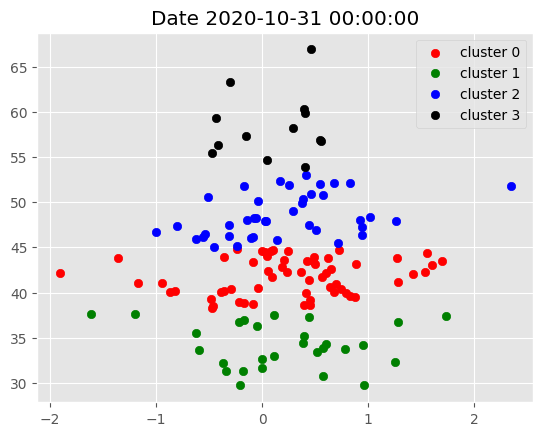

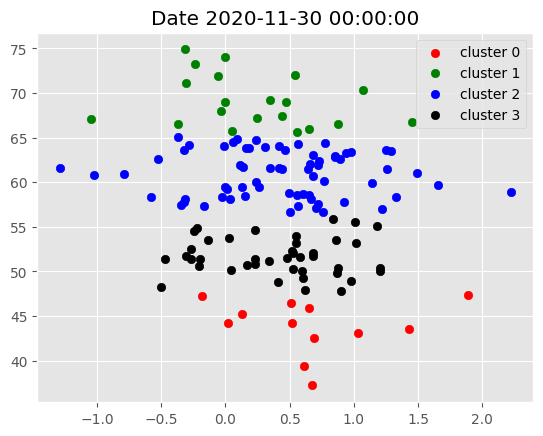

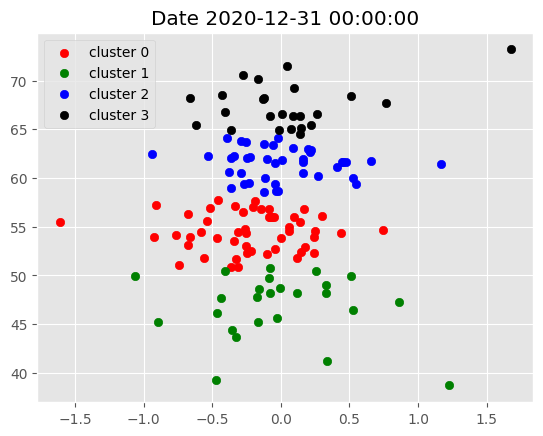

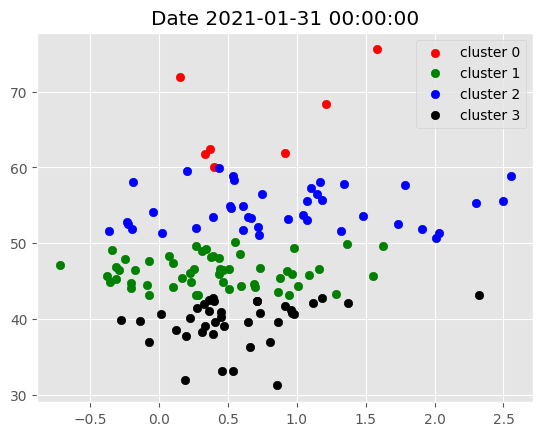

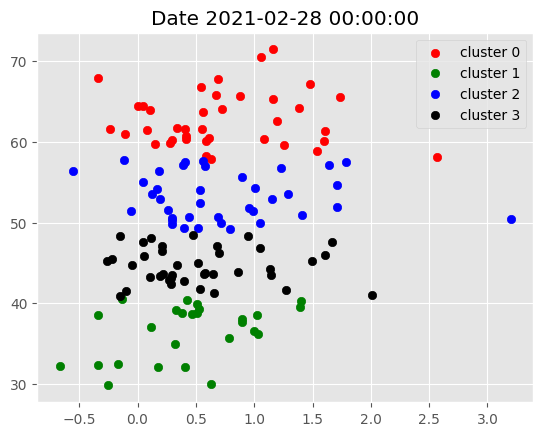

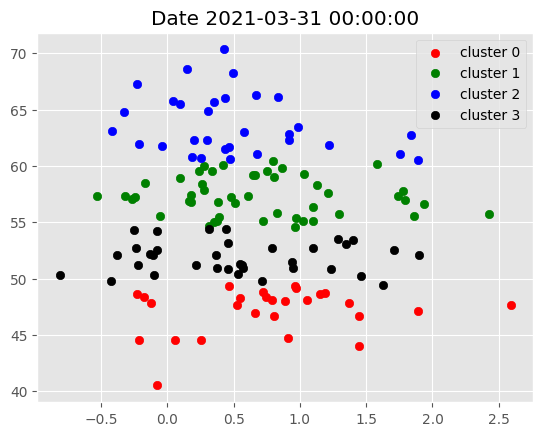

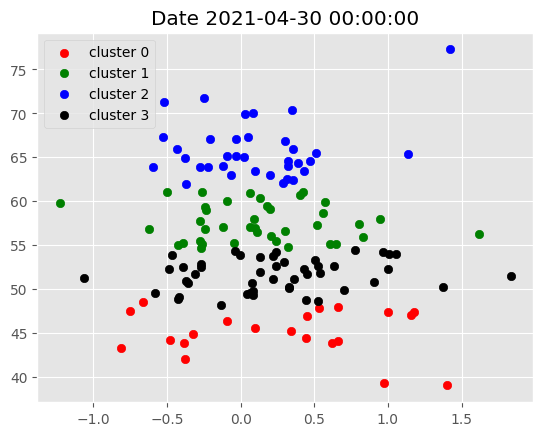

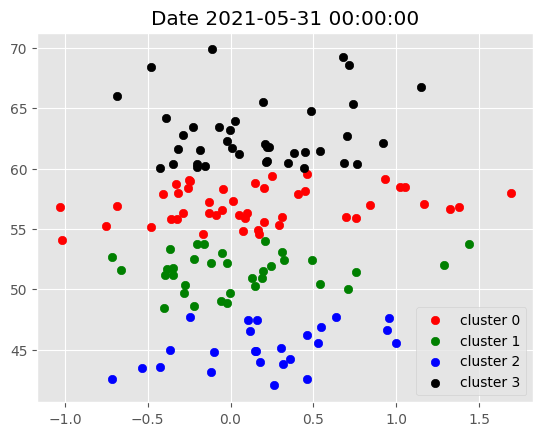

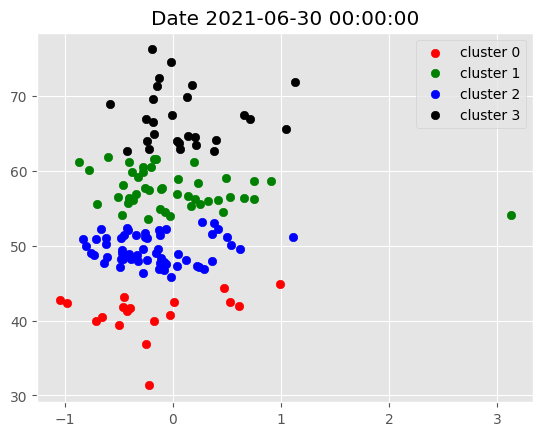

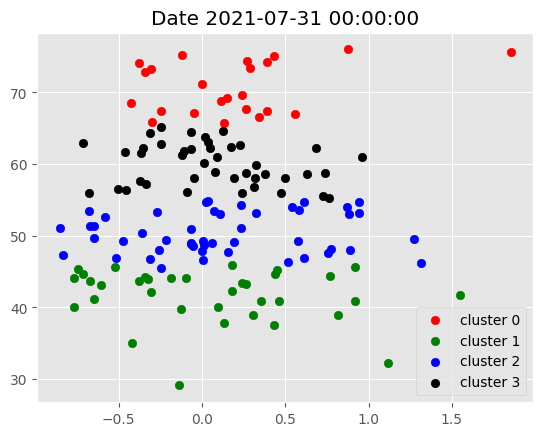

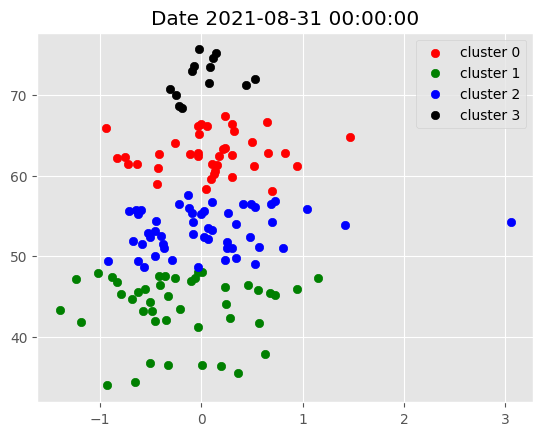

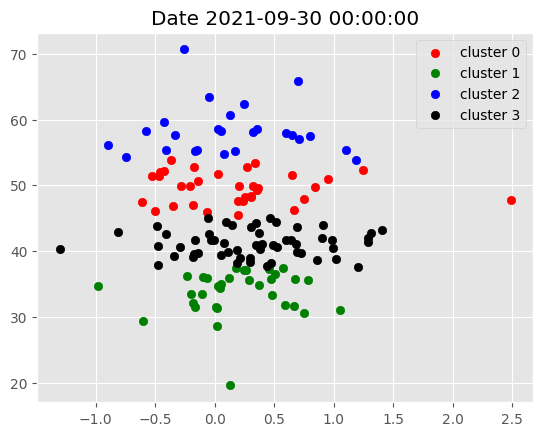

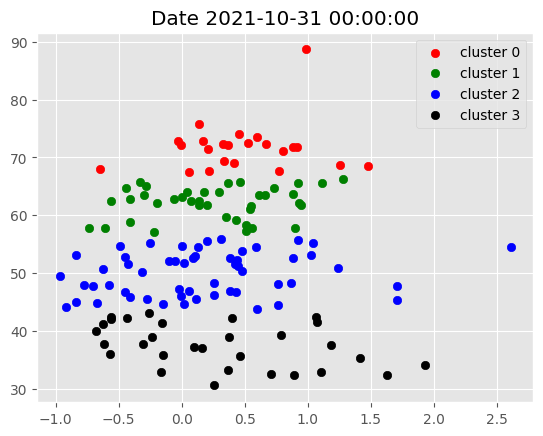

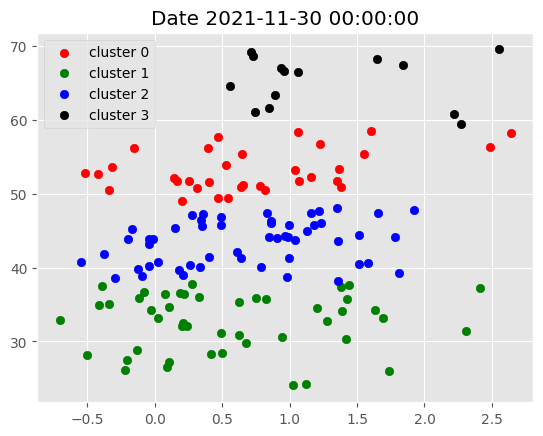

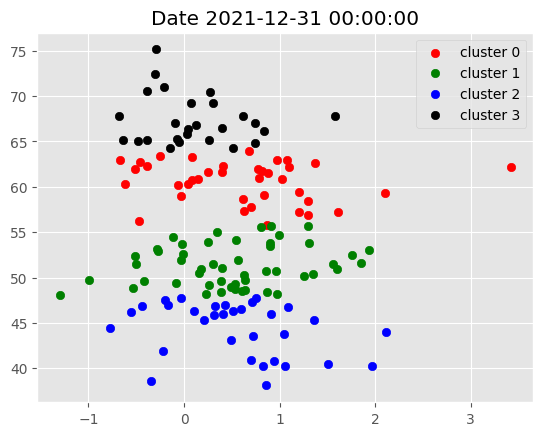

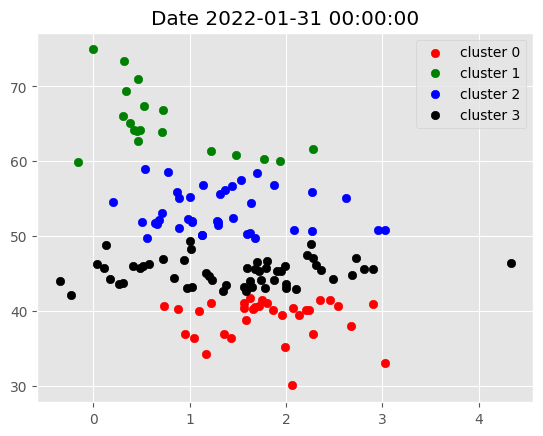

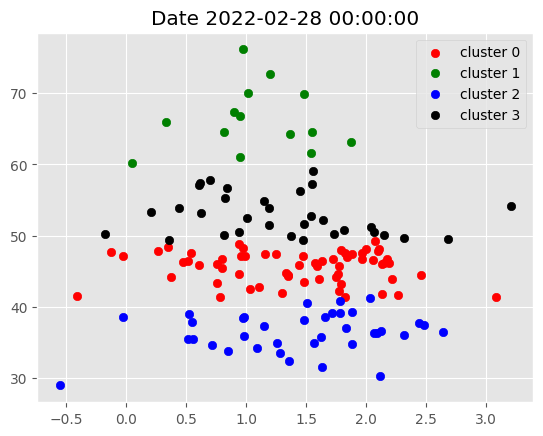

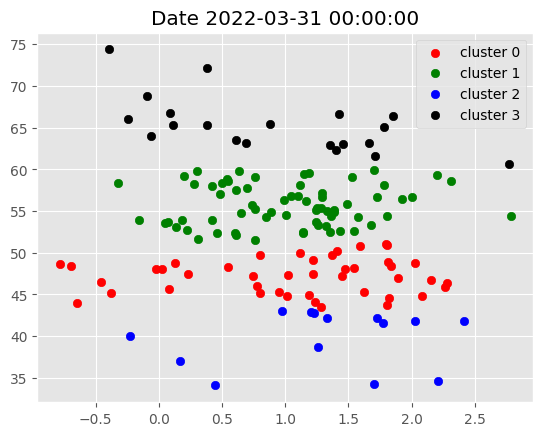

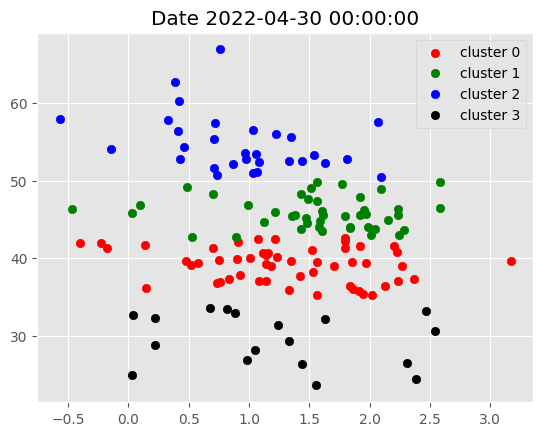

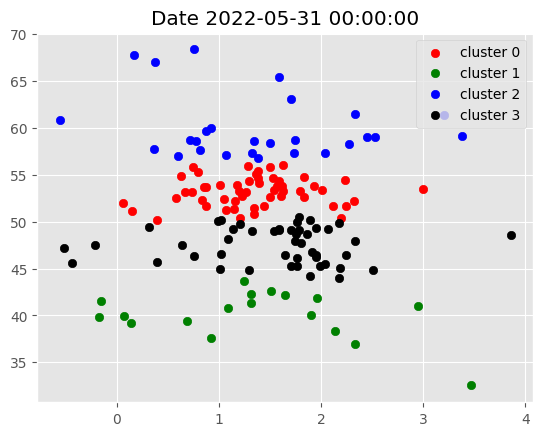

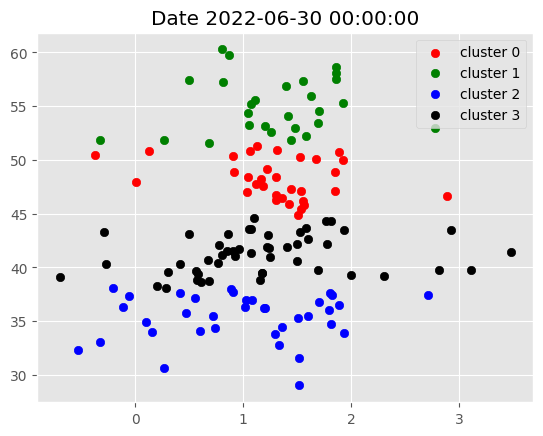

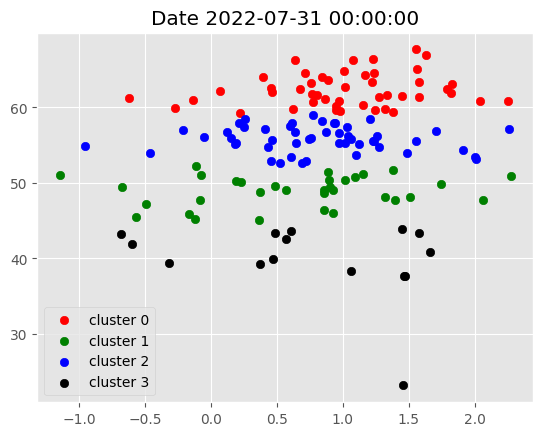

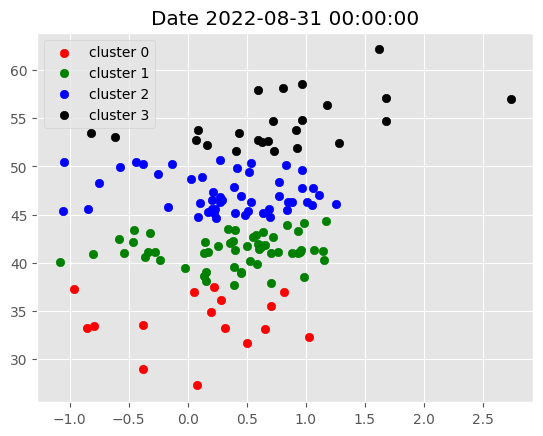

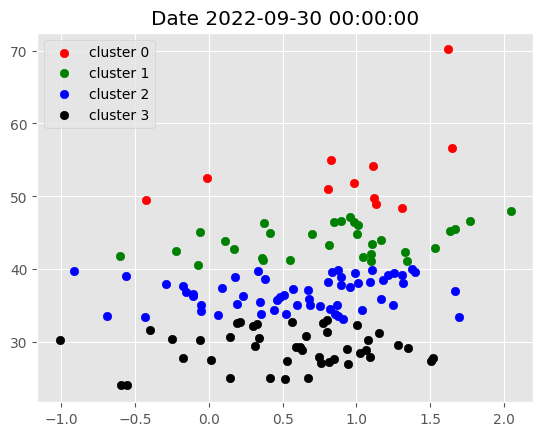

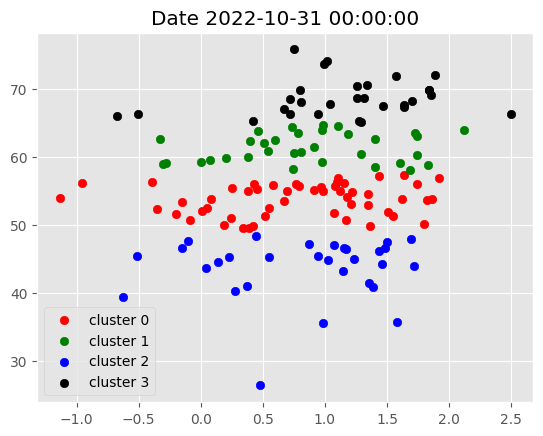

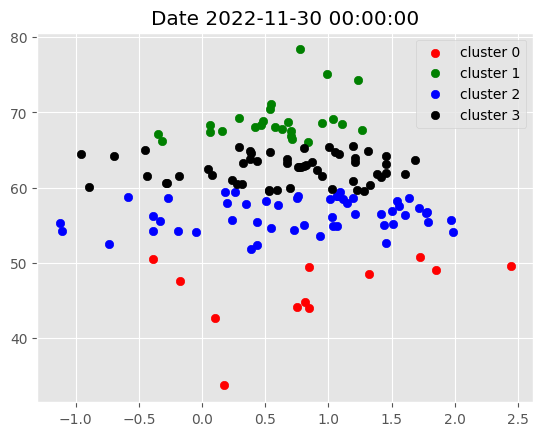

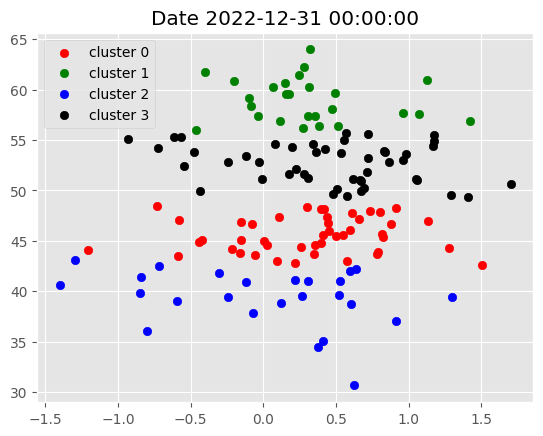

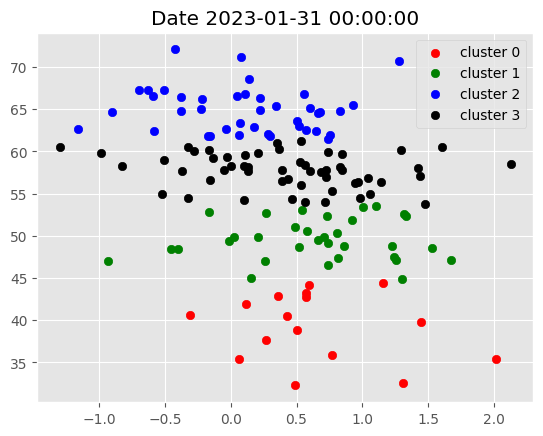

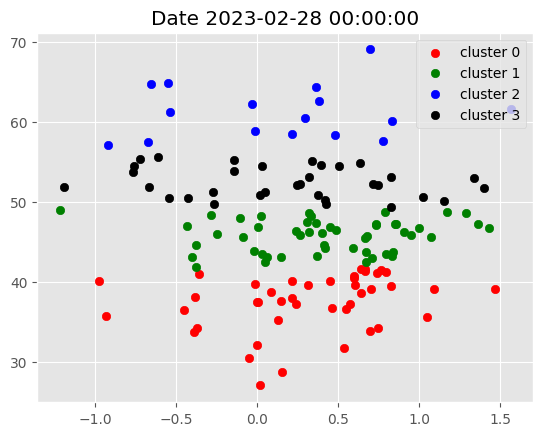

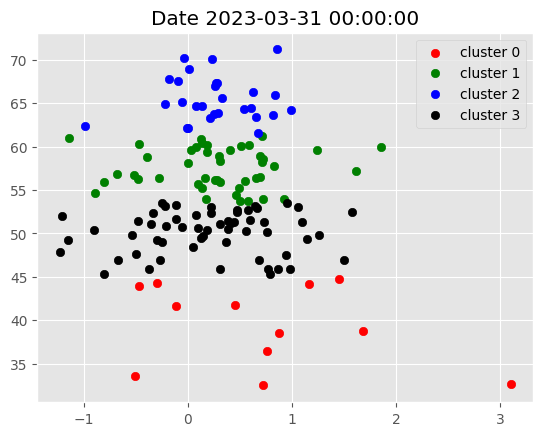

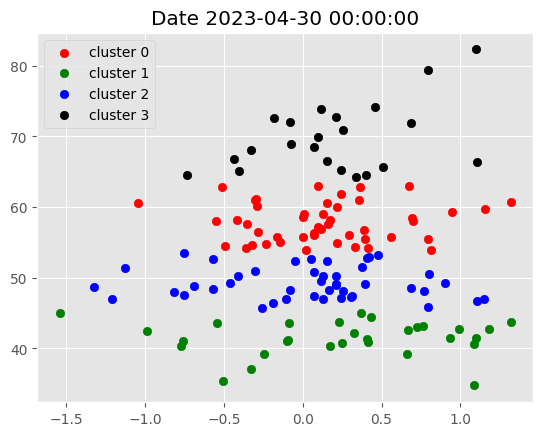

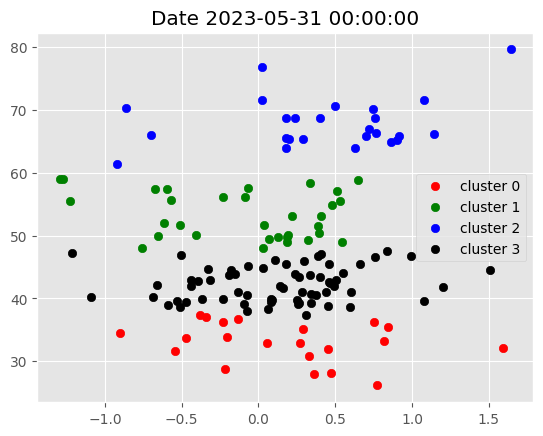

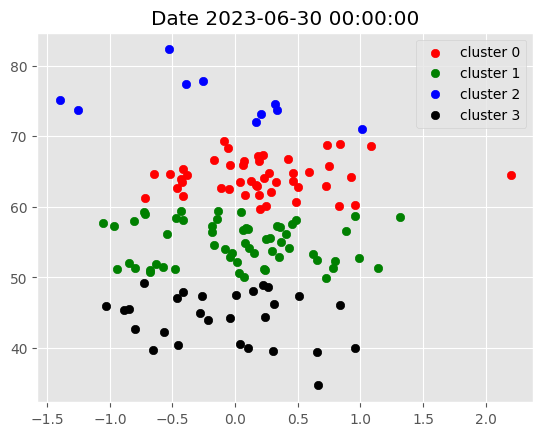

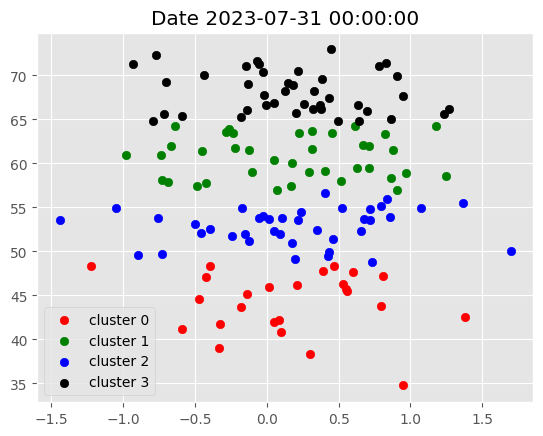

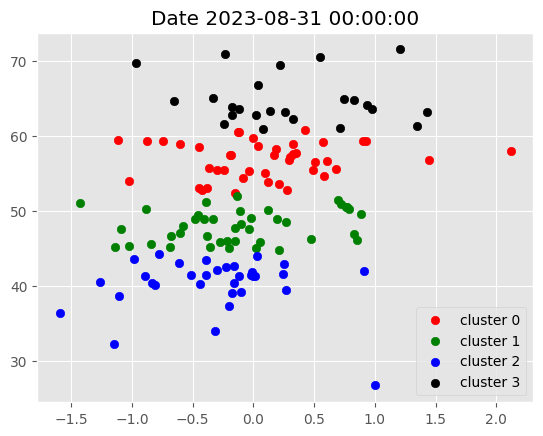

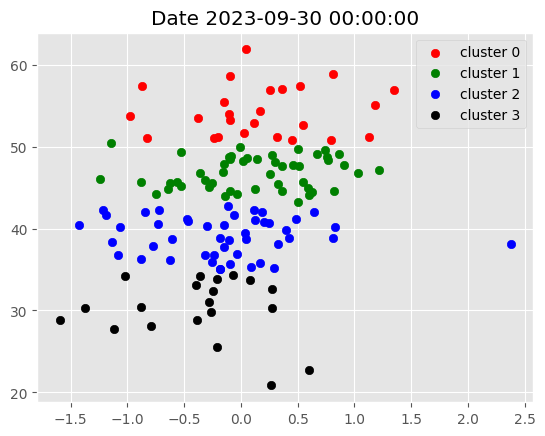

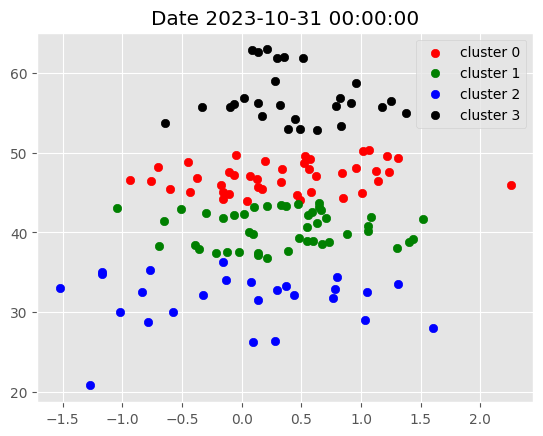

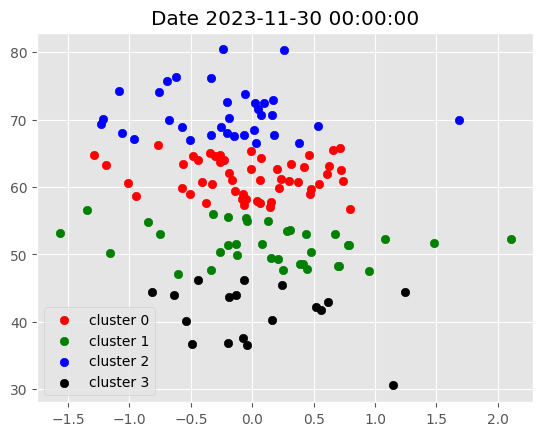

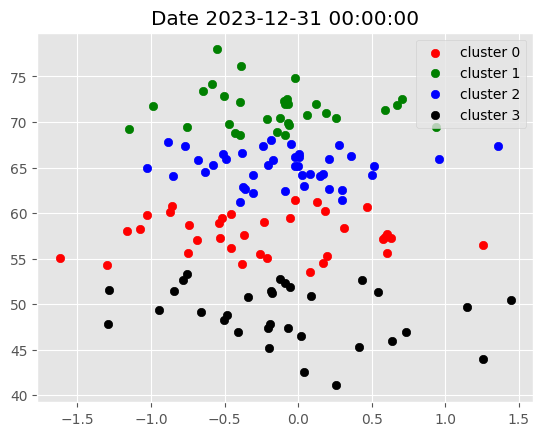

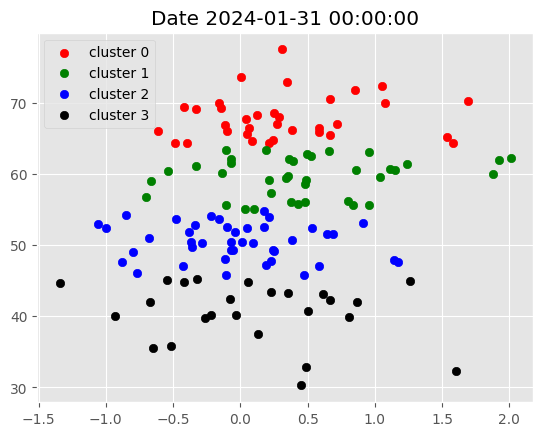

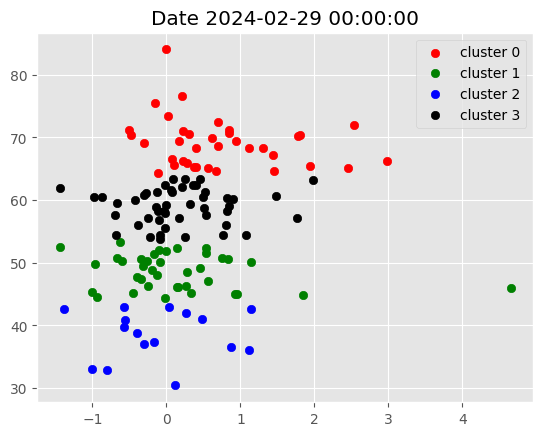

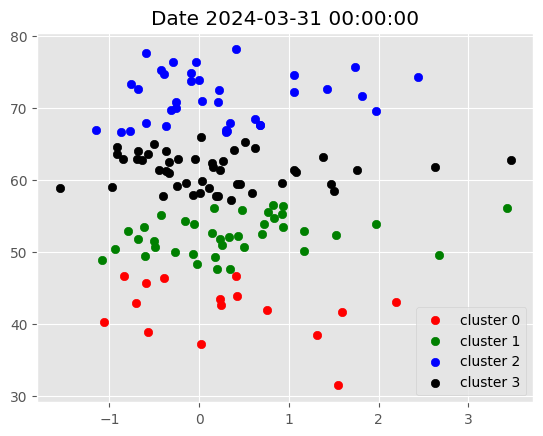

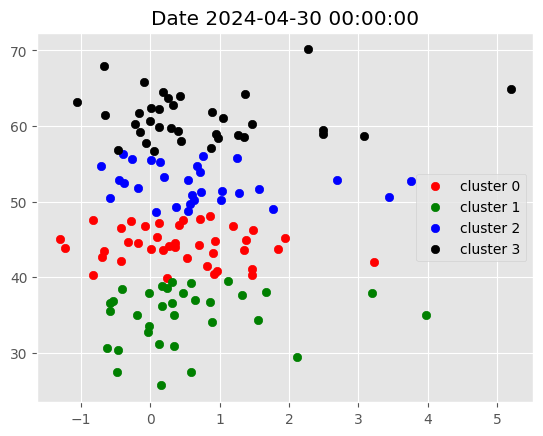

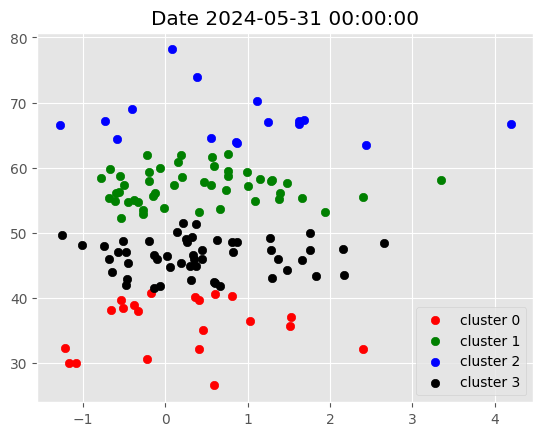

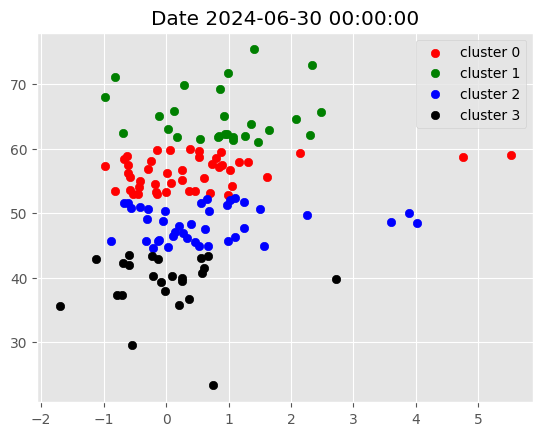

In [32]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():

  g= data.xs(i, level=0)

  plt.title(f'Date {i}')

  plot_clusters(g)

##Apply pre-defined centroids

In [35]:
target_rsi_values = [30, 45, 55, 70]

intial_centroids = np.zeros((len(target_rsi_values), 18))

intial_centroids[:, 6] = target_rsi_values

intial_centroids

array([[ 0.,  0.,  0.,  0.,  0.,  0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]])

In [36]:
from sklearn.cluster import KMeans

data = data.drop('cluster', axis=1)
def get_clusters(df):
  df['cluster'] = KMeans(n_clusters=4,
                         random_state=0,
                         init=intial_centroids).fit(df).labels_
  return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

data

atr   bb_high    bb_low    bb_mid  garman_klass_vol  \
date       ticker                                                             
2018-07-31 AAL     0.794336  3.699472  3.591909  3.645691          0.000092   
           AAPL   -1.073866  3.860463  3.808181  3.834322         -0.000885   
           ABBV    0.047627  4.341630  4.234662  4.288146         -0.025348   
           ABT    -0.940371  4.114918  4.021121  4.068020         -0.003467   
           ACN    -0.835028  5.058385  4.997519  5.027952         -0.003209   
...                     ...       ...       ...       ...               ...   
2024-06-30 VRTX    1.313968  6.194524  6.135570  6.165047          0.000173   
           VZ     -0.606494  3.759060  3.698619  3.728839          0.000201   
           WFC     0.369039  4.110066  4.051801  4.080934          0.000079   
           WMT     1.258892  4.245980  4.197531  4.221755          0.000064   
           XOM     0.457795  4.772566  4.692969  4.732767          0.000114   

                       macd        rsi  return_1m  return_2m  return_3m  \
date       ticker                                                         
2018-07-31 AAL    -0.297513  49.117687   0.041623  -0.047041  -0.026289   
           AAPL   -0.163311  52.605230   0.027983   0.009109   0.049478   
           ABBV   -0.726975  45.920927   0.005633  -0.029587  -0.011801   
           ABT     0.529881  62.882447   0.079433   0.034389   0.042361   
           ACN    -0.172550  42.887954  -0.026040   0.011460   0.017611   
...                     ...        ...        ...        ...        ...   
2024-06-30 VRTX    1.432555  57.870674   0.029385   0.092359   0.038904   
           VZ      0.438589  57.417661   0.002187   0.021917  -0.000415   
           WFC    -0.447230  53.367651  -0.008845   0.003462   0.010086   
           WMT     1.953787  61.898824   0.029653   0.069957   0.041337   
           XOM    -0.324234  53.431096  -0.018250  -0.009408  -0.000531   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2018-07-31 AAL     -0.050880  -0.017899   -0.019393  1.202496  1.530517   
           AAPL     0.022909   0.014540    0.022060  1.318268 -0.329260   
           ABBV    -0.028860   0.005494    0.026310  0.477782  0.507645   
           ABT      0.010427   0.022867    0.025837  0.787255 -0.128957   
           ACN      0.000037   0.013581    0.019435  1.213839 -0.190147   
...                      ...        ...         ...       ...       ...   
2024-06-30 VRTX     0.023857   0.033729    0.024173  0.509512  0.091933   
           VZ       0.020633   0.032199    0.014692  0.468973 -0.455689   
           WFC      0.033991   0.044934    0.030437  1.088353 -0.098942   
           WMT      0.044342   0.028130    0.022803  0.616885 -0.391019   
           XOM      0.026742   0.000589    0.008824  1.069147  0.144807   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2018-07-31 AAL     0.397559  0.197123  0.823948        1  
           AAPL   -0.628205  0.427703  0.622943        2  
           ABBV   -0.202965  0.535353  0.469552        1  
           ABT    -0.439399  0.243872  0.934529        3  
           ACN    -0.253472  0.340847  0.082172        1  
...                     ...       ...       ...      ...  
2024-06-30 VRTX   -0.891581  0.067606  0.854369        2  
           VZ      0.229425  0.187526  0.226230        2  
           WFC     1.567178 -0.738443 -0.867935        2  
           WMT    -0.373268  0.212561  0.684859        3  
           XOM     0.843598 -0.485055  0.434796        2  

[10170 rows x 19 columns]

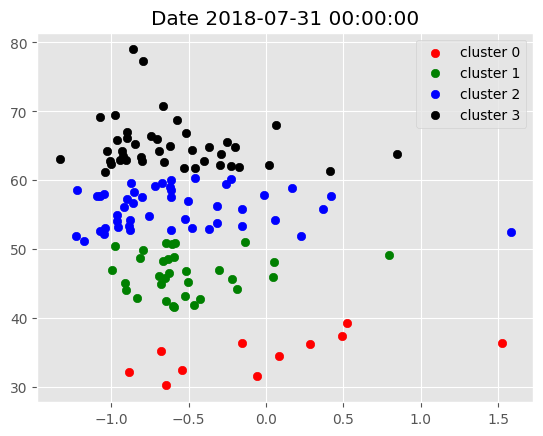

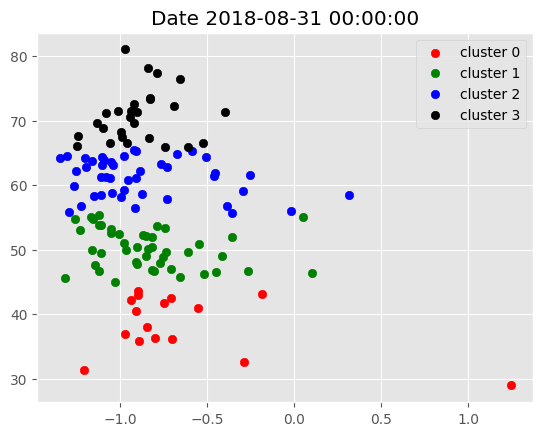

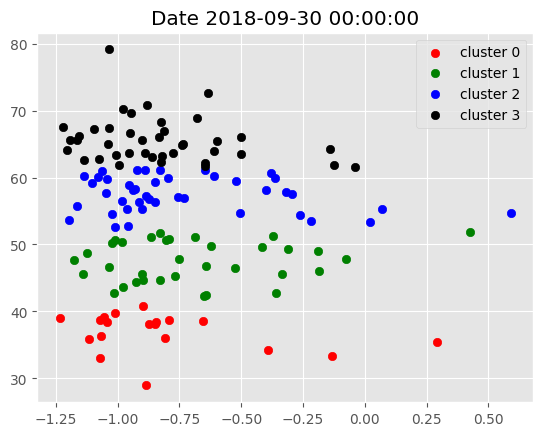

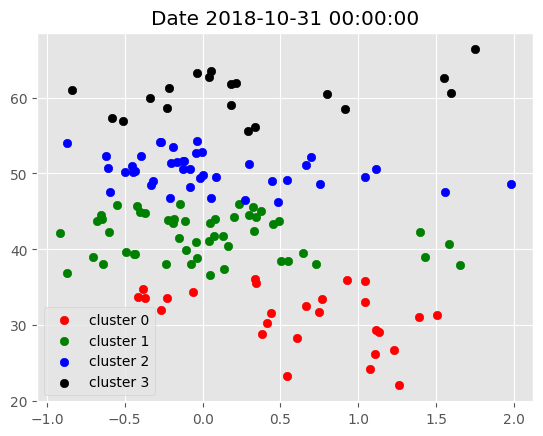

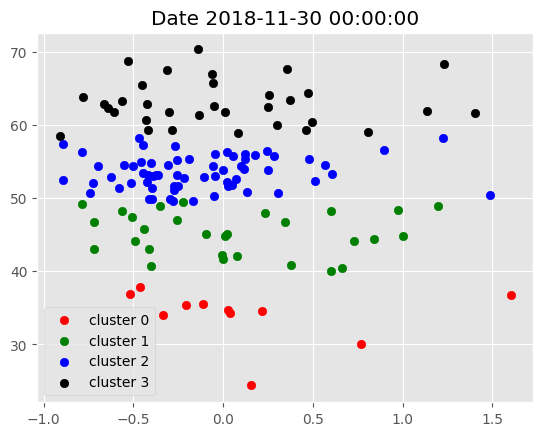

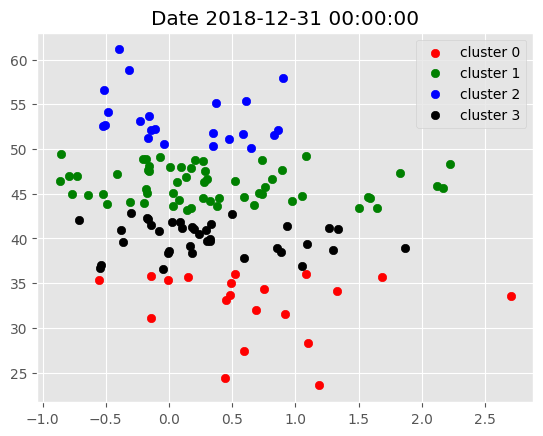

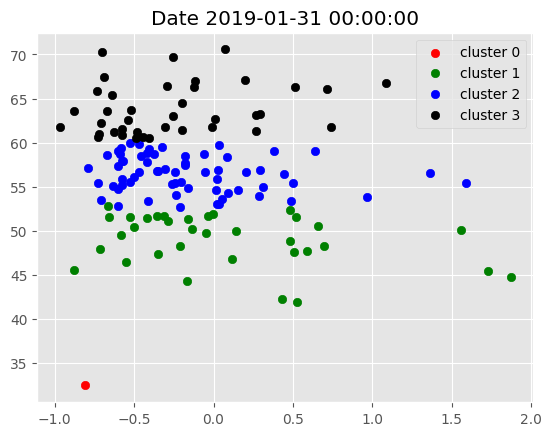

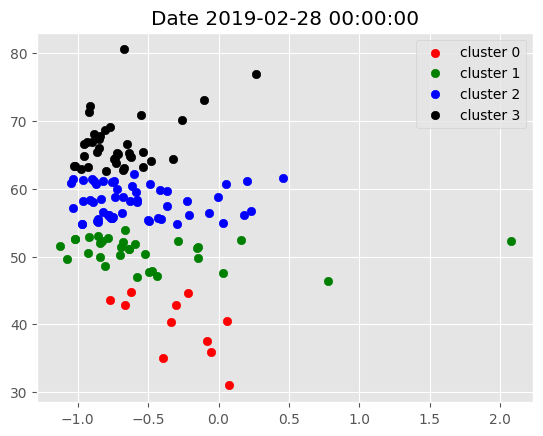

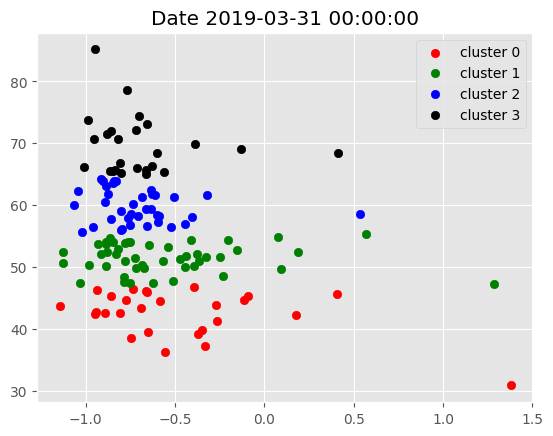

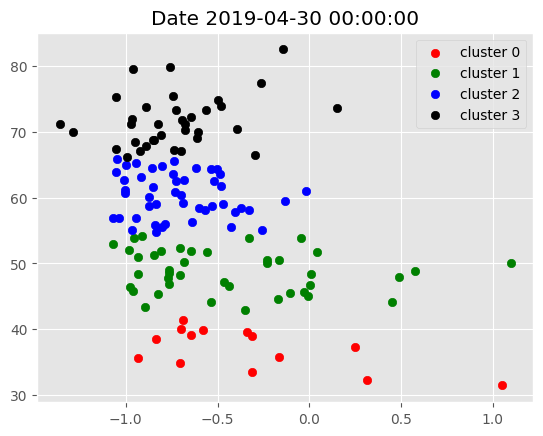

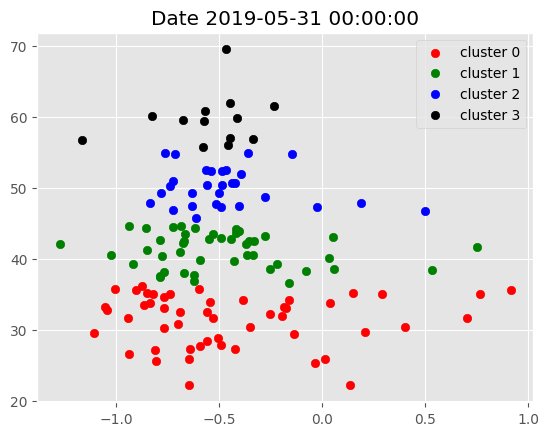

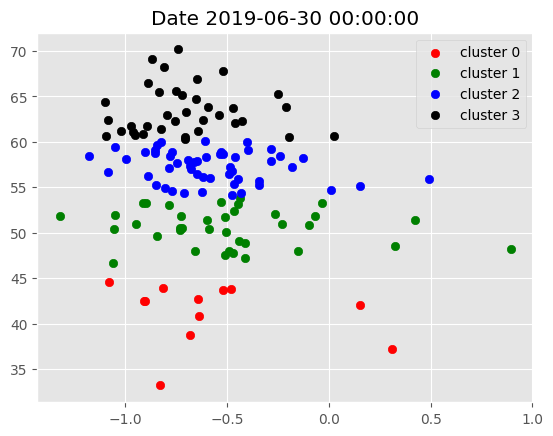

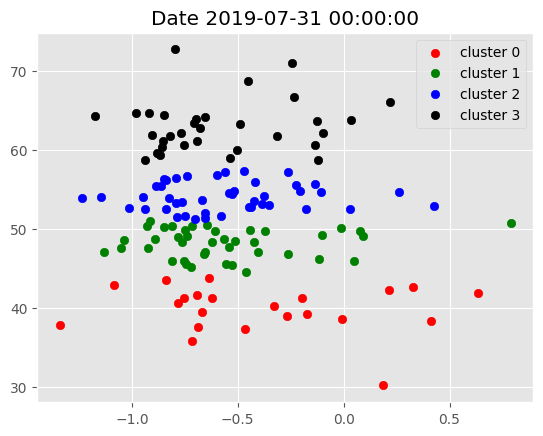

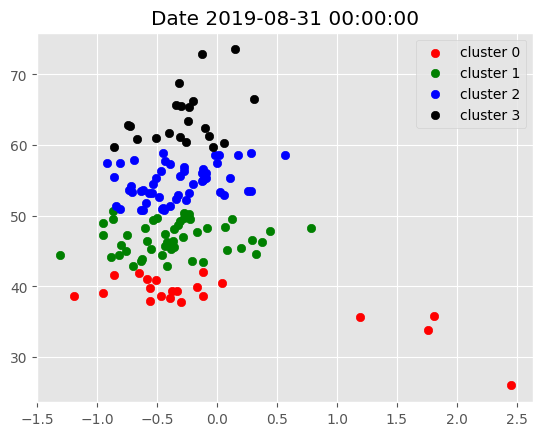

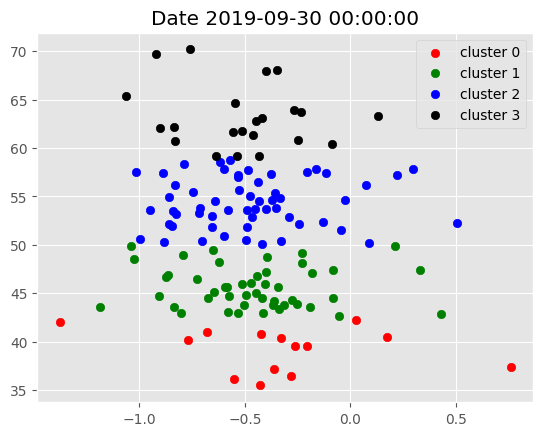

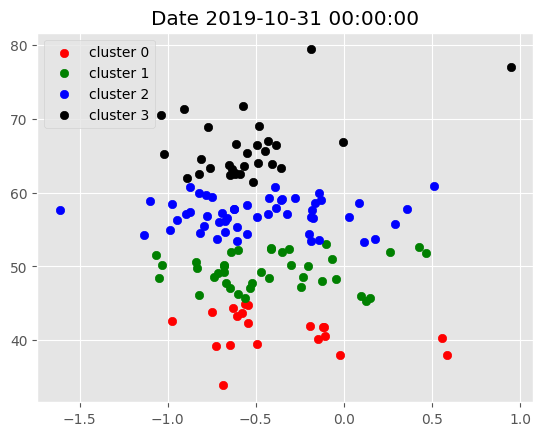

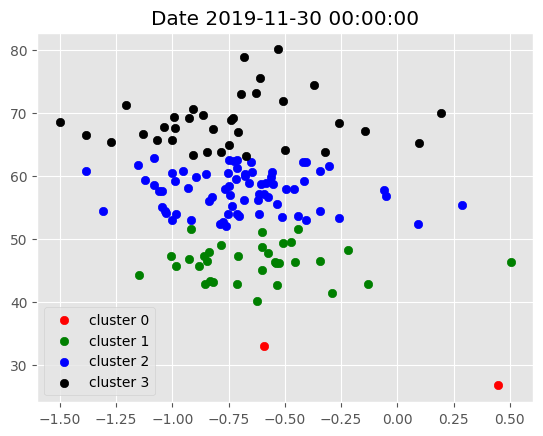

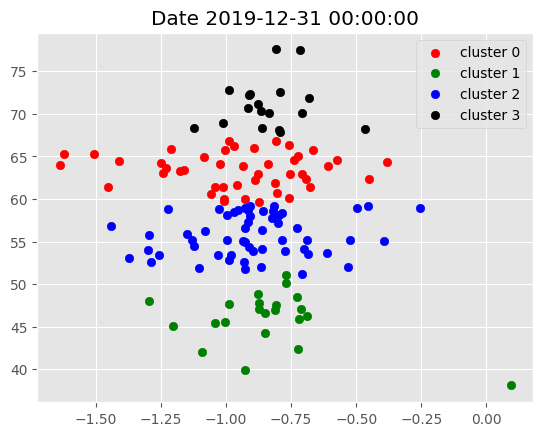

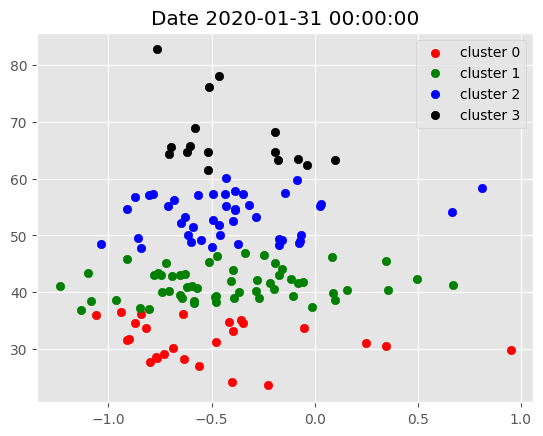

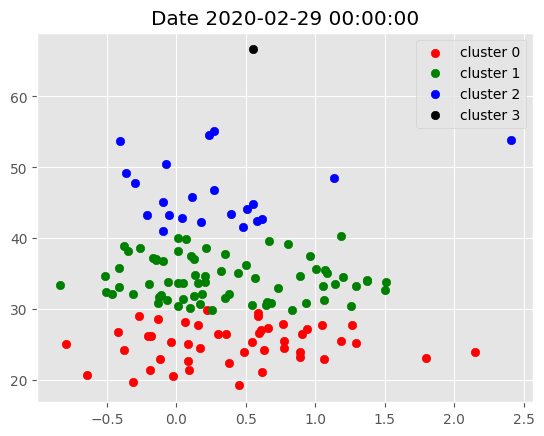

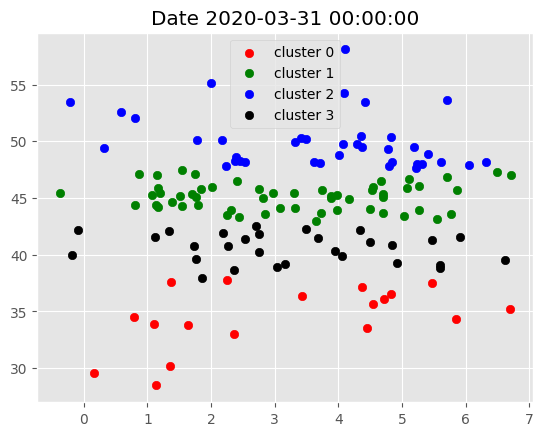

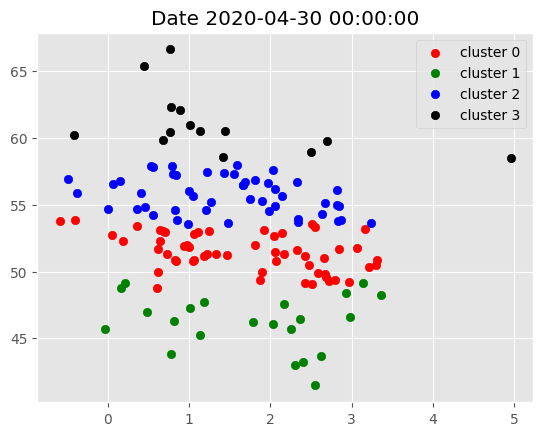

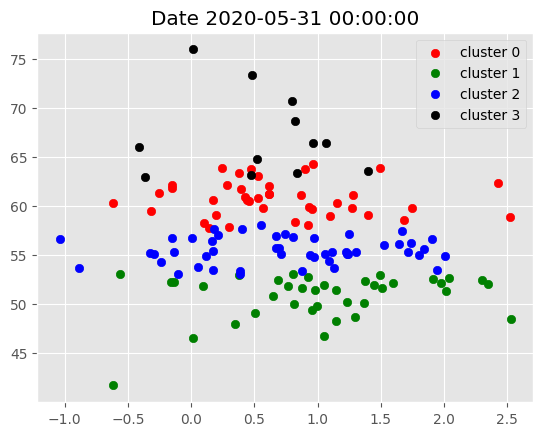

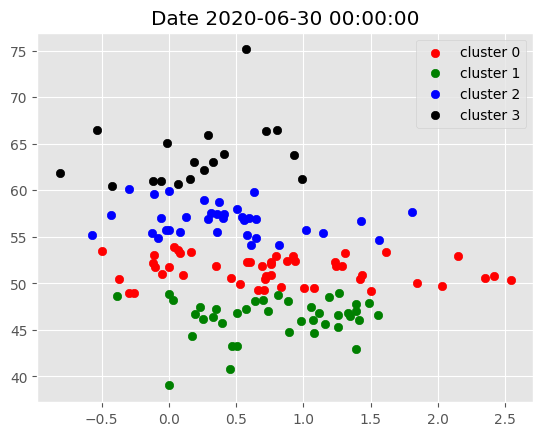

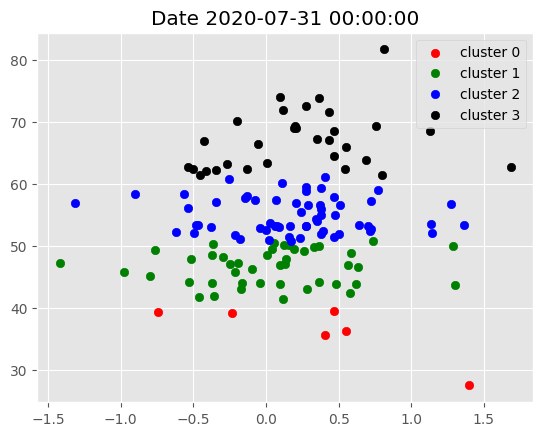

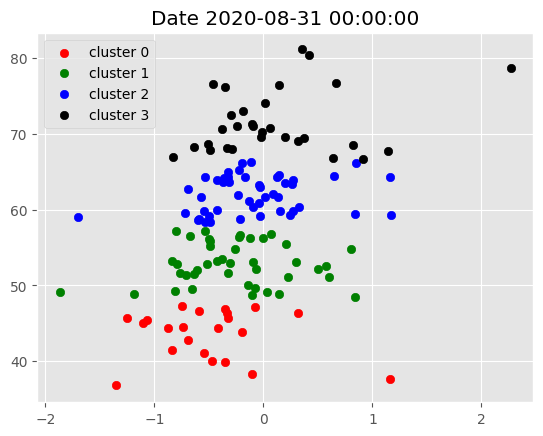

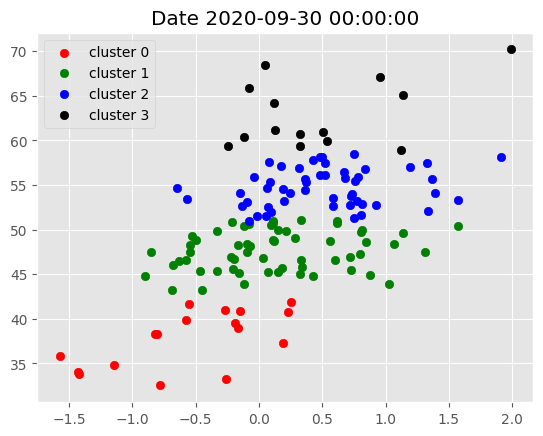

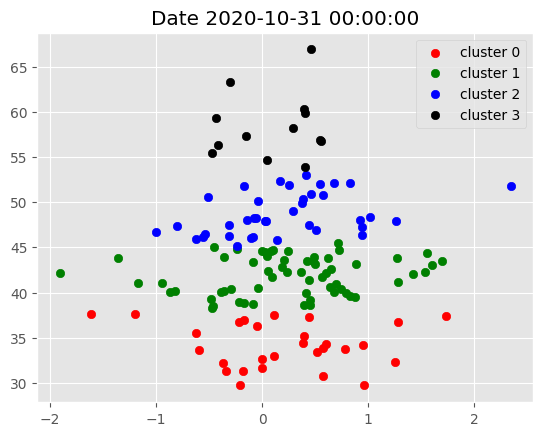

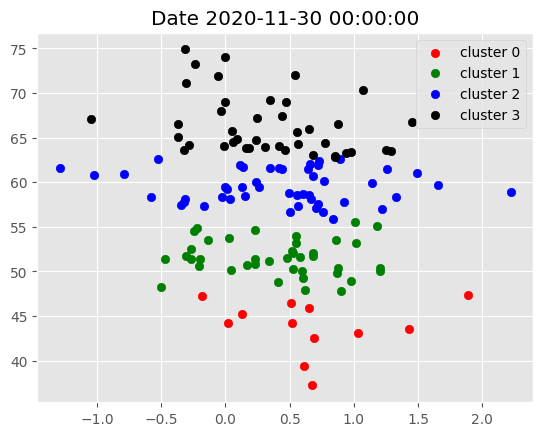

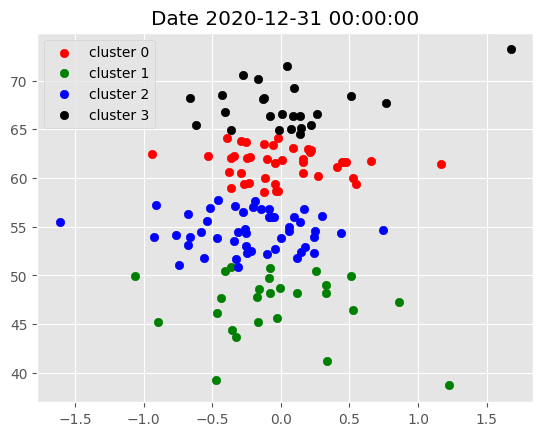

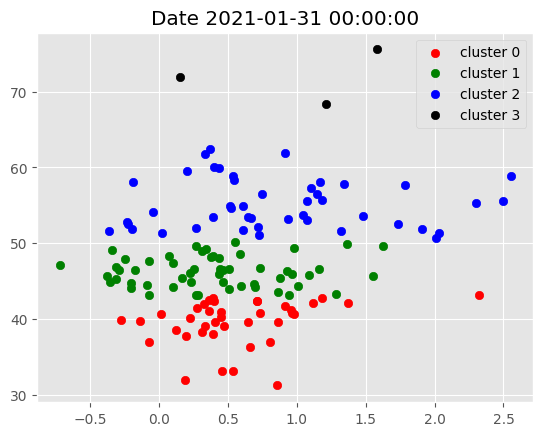

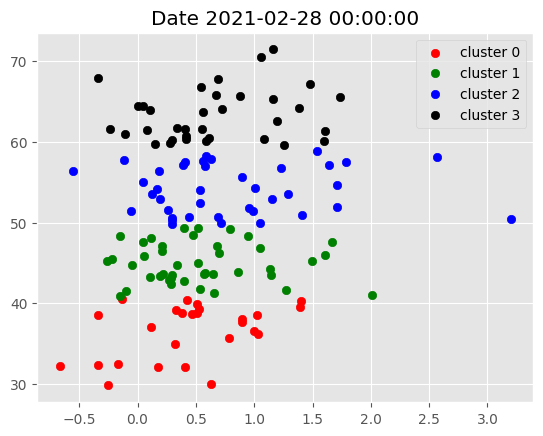

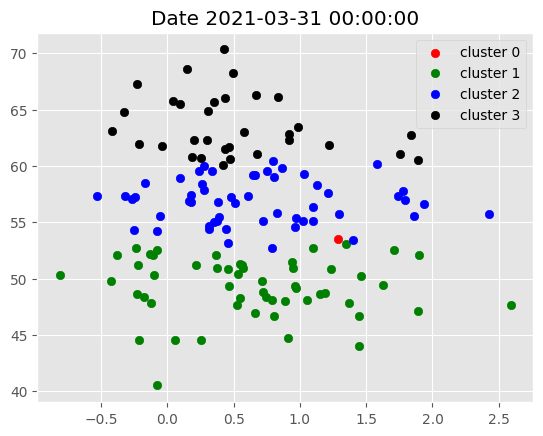

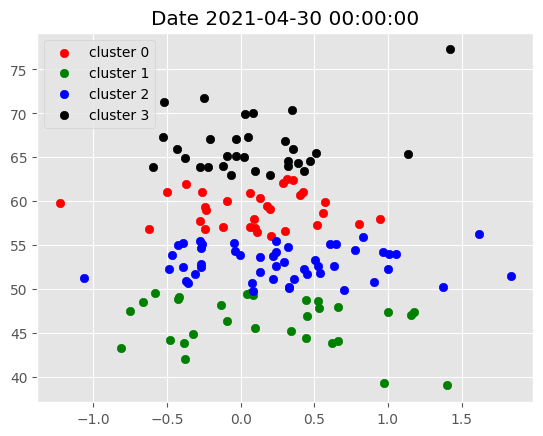

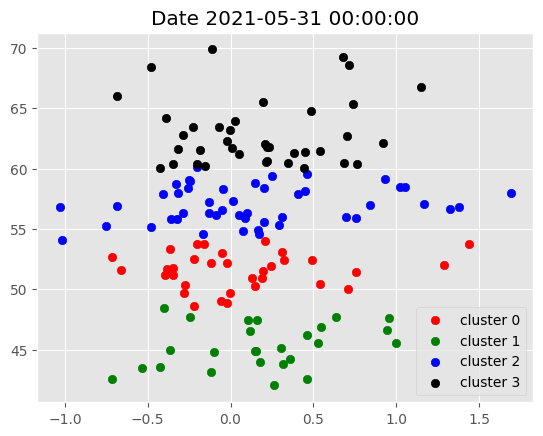

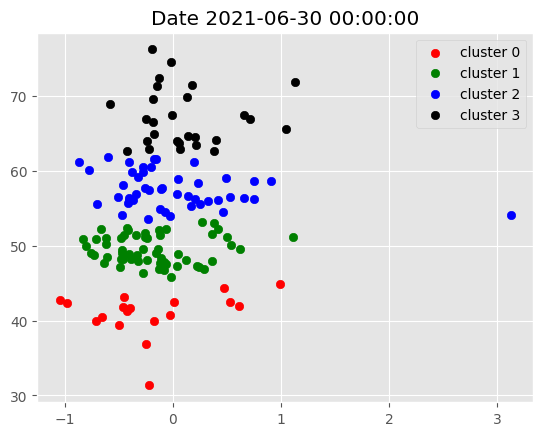

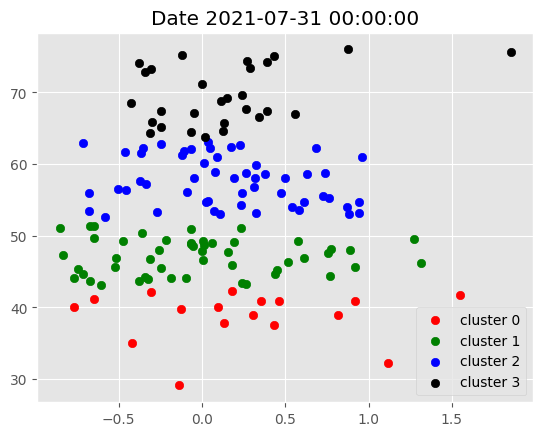

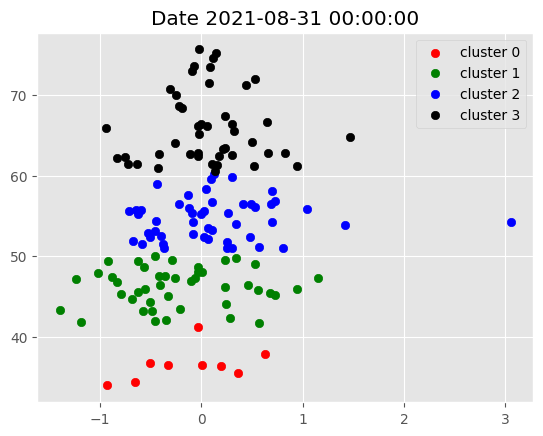

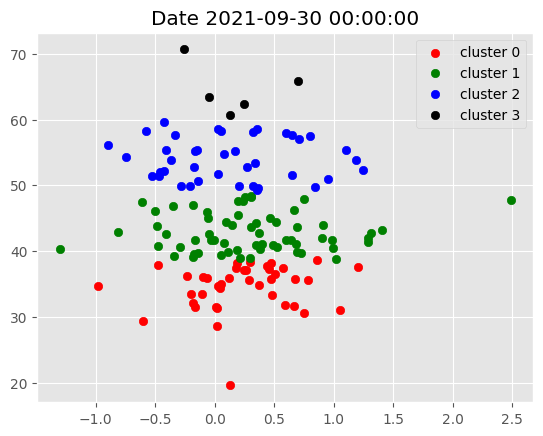

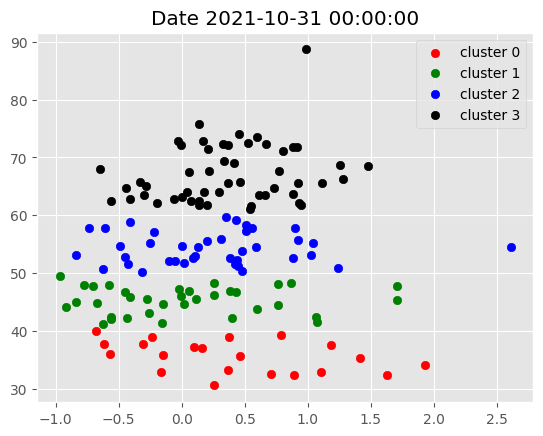

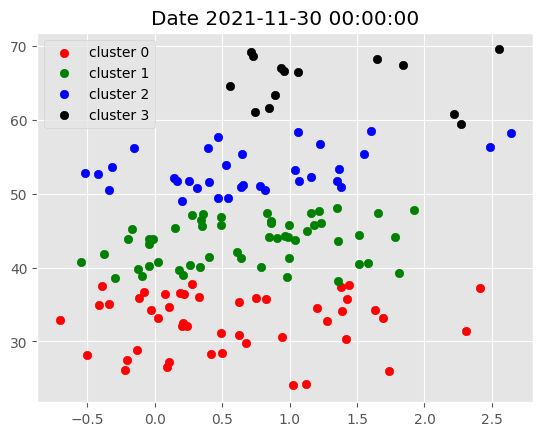

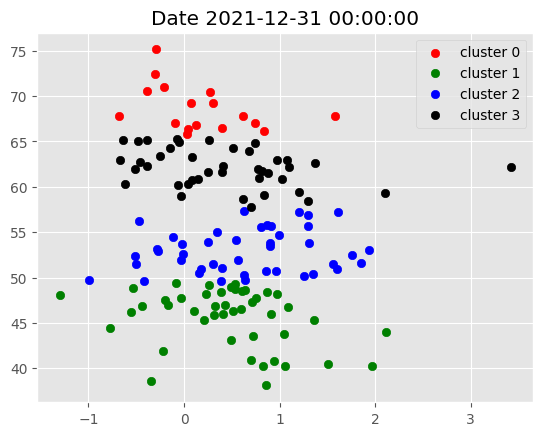

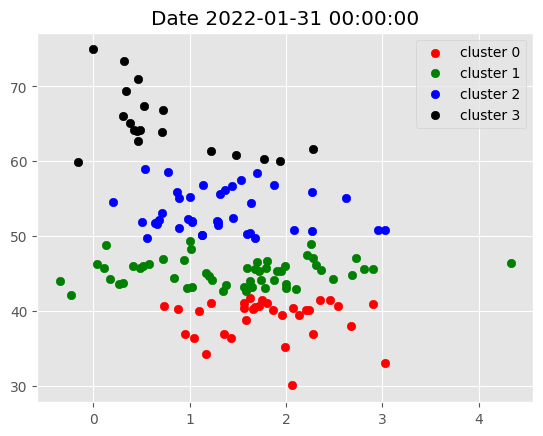

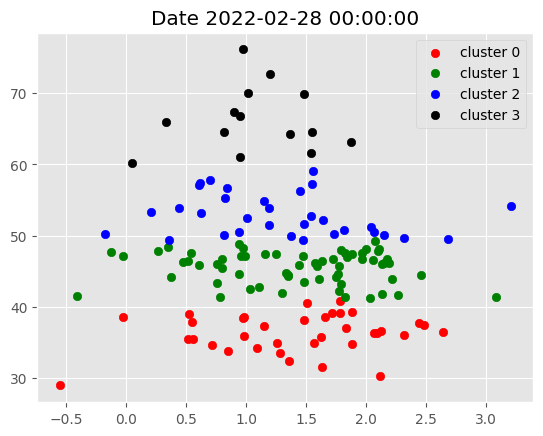

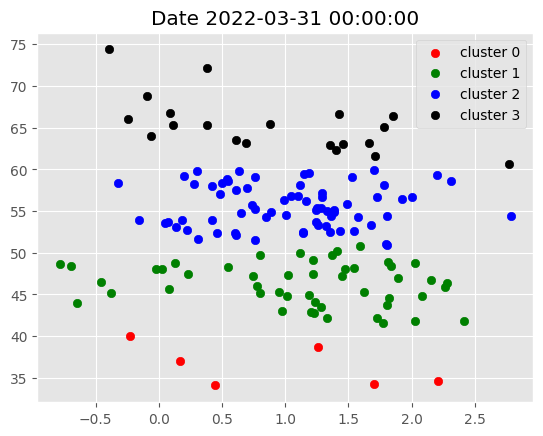

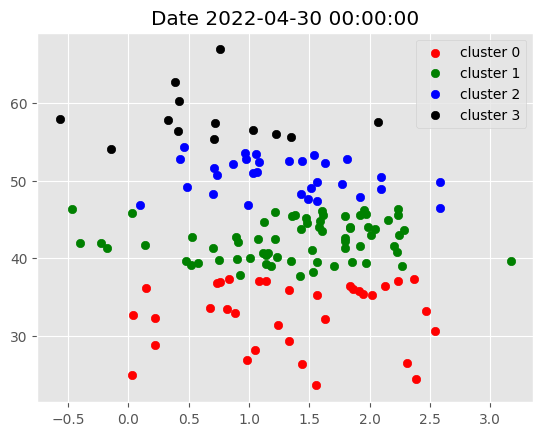

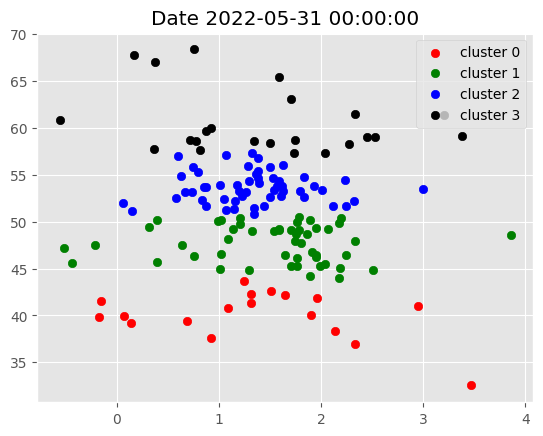

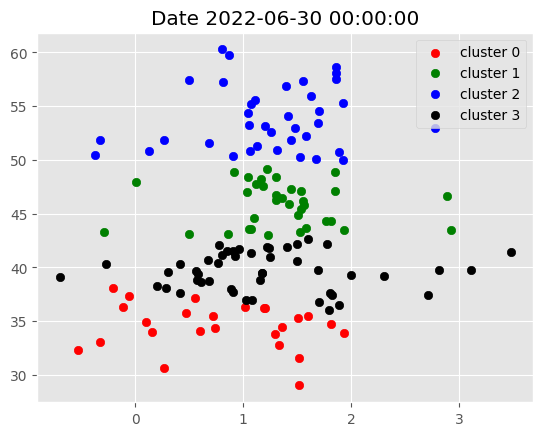

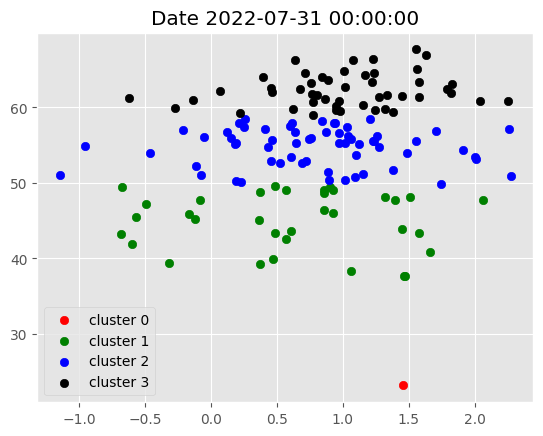

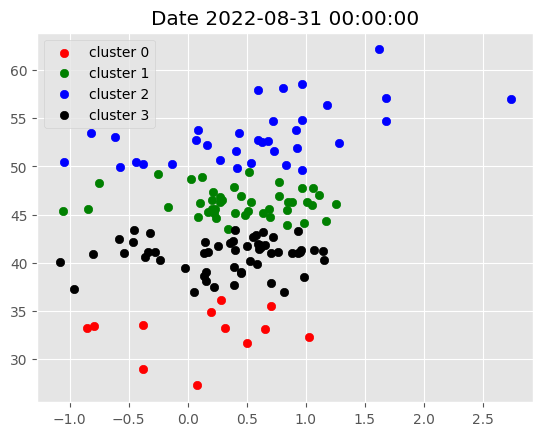

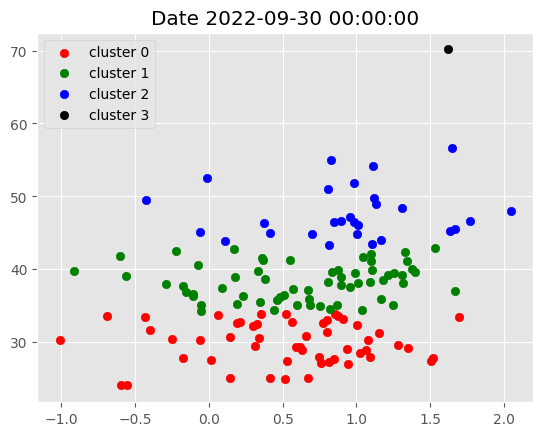

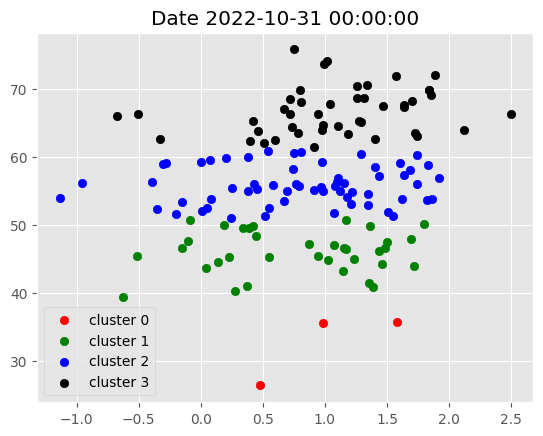

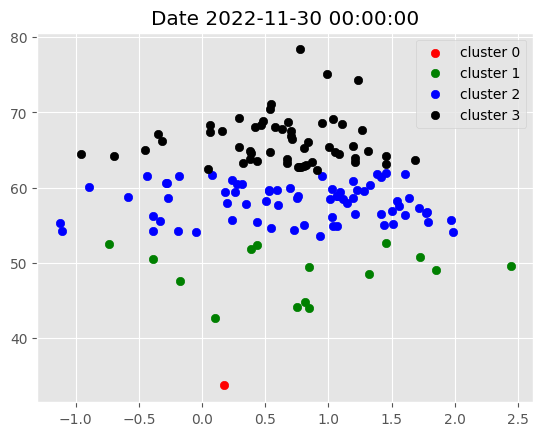

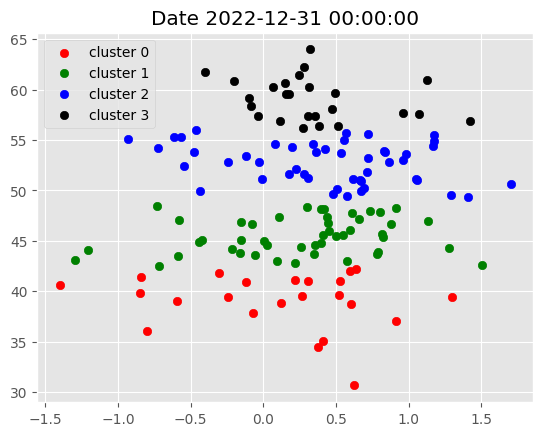

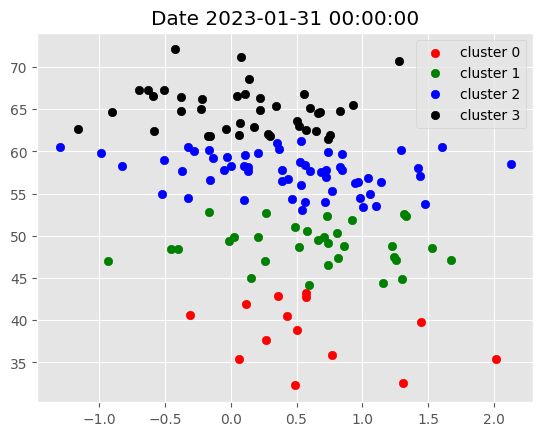

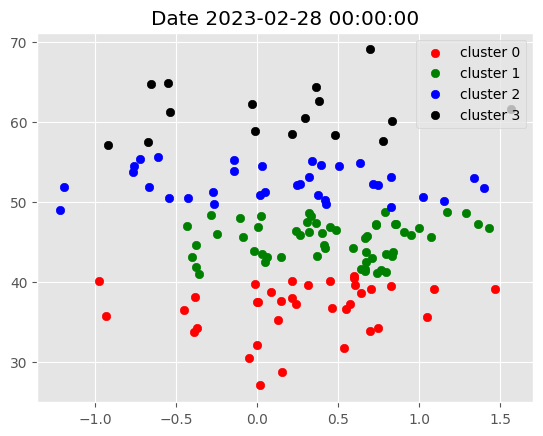

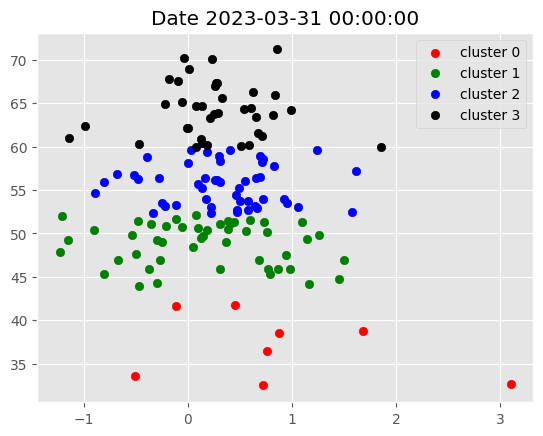

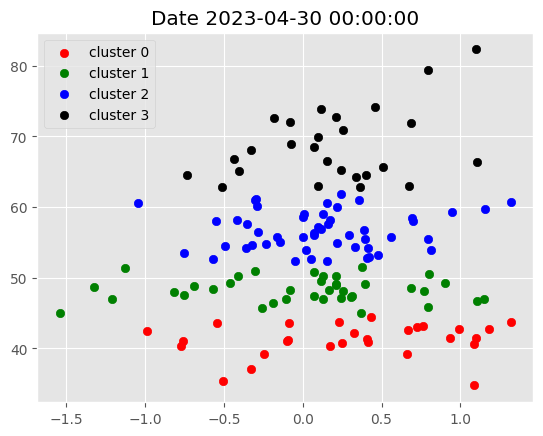

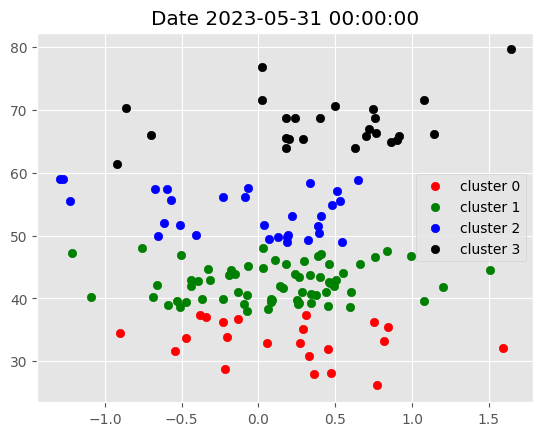

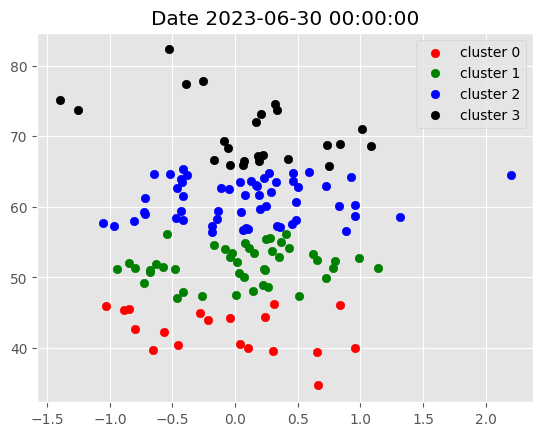

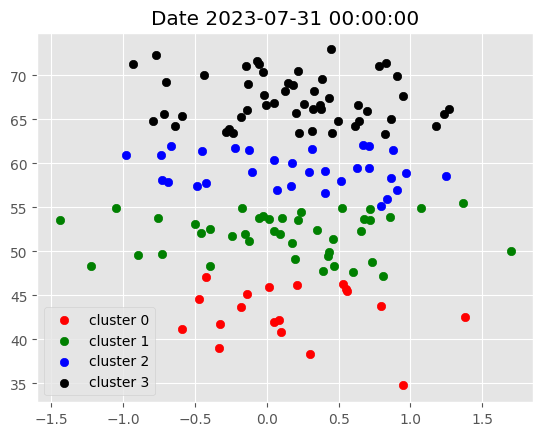

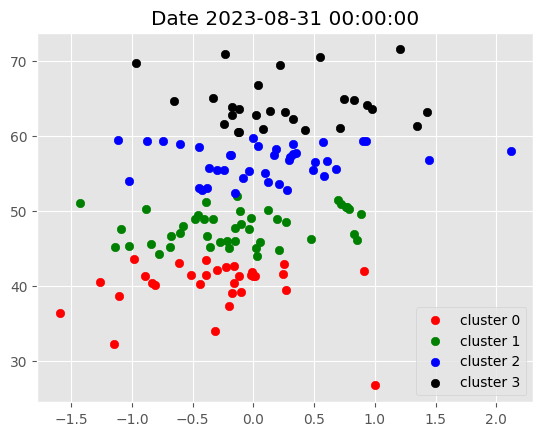

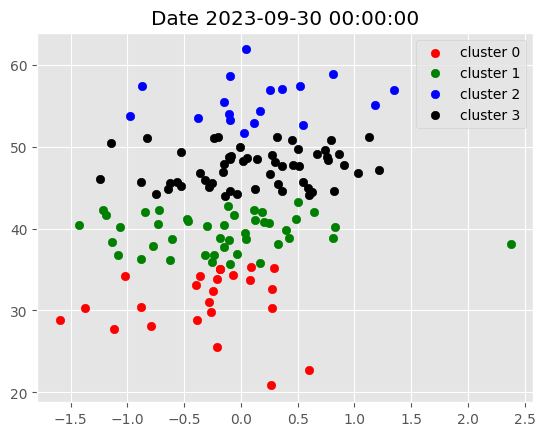

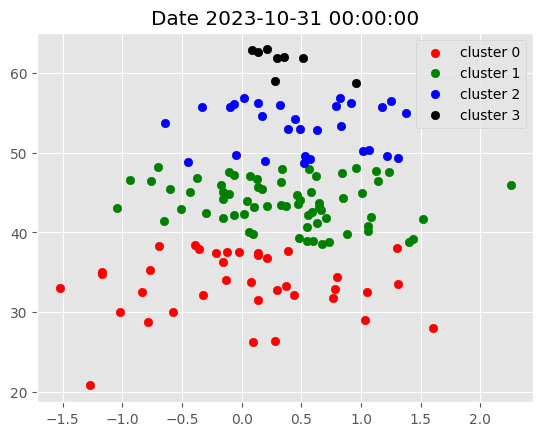

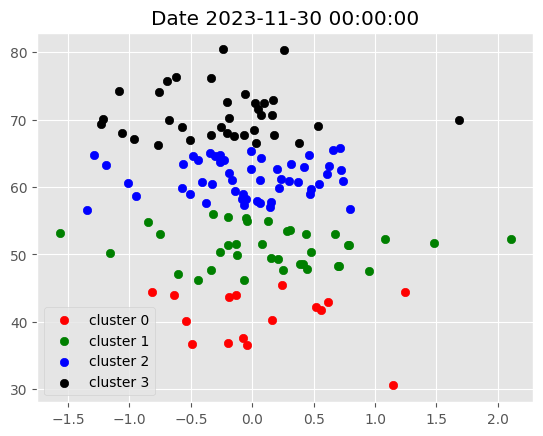

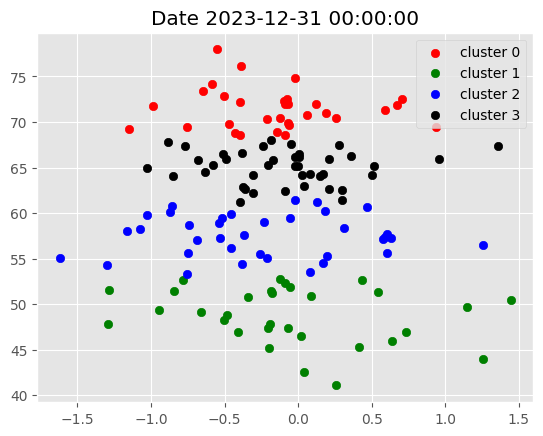

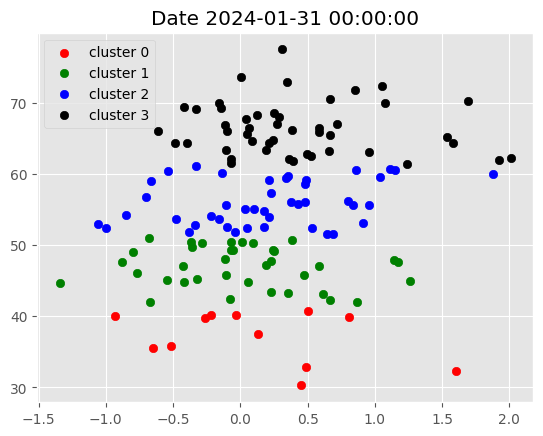

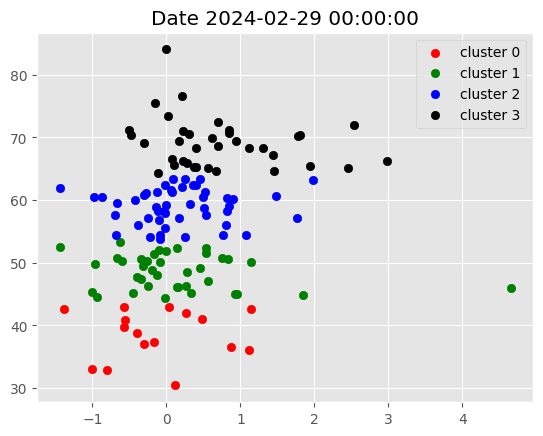

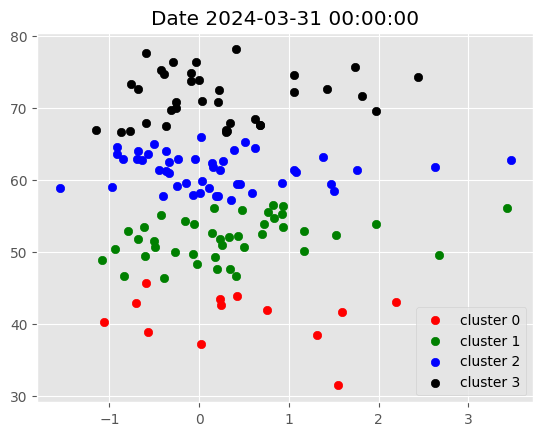

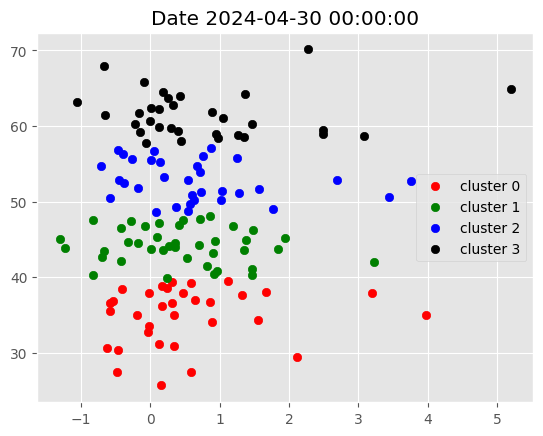

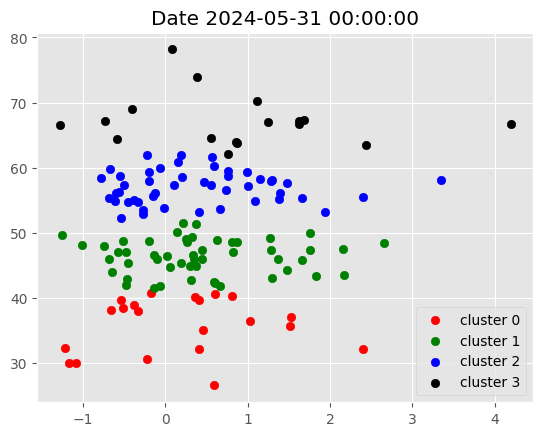

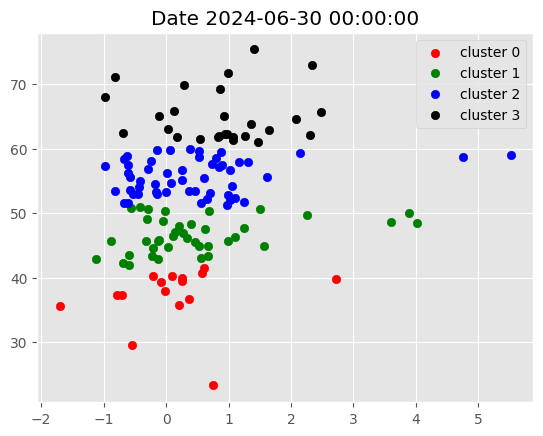

In [37]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():

  g= data.xs(i, level=0)

  plt.title(f'Date {i}')

  plot_clusters(g)

## 7. For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization

* First we will filter only stocks corresponding to the cluster we choose based on our hypothesis.

* Momentum is persistent and my idea would be that stocks clustered around RSI 70 centroid should continue to outperform in the following month - thus I would select stocks corresponding to cluster 3.

In [48]:
filtered_df = data[data['cluster']==3].copy()

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:

    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()

fixed_dates

{'2018-08-01': ['ABT',
  'AMD',
  'AMGN',
  'AMT',
  'BDX',
  'BMY',
  'CMCSA',
  'COST',
  'CSX',
  'DIS',
  'ELV',
  'EOG',
  'EXPE',
  'GILD',
  'HON',
  'JNJ',
  'JPM',
  'KO',
  'LLY',
  'LUV',
  'MDLZ',
  'MDT',
  'MMM',
  'MRK',
  'ORLY',
  'PEP',
  'PFE',
  'PG',
  'PM',
  'QCOM',
  'REGN',
  'RTX',
  'SHW',
  'TGT',
  'TJX',
  'TMO',
  'UAL',
  'UNP',
  'UPS',
  'USB',
  'VLO',
  'WMT'],
 '2018-09-01': ['AAPL',
  'ADP',
  'AMD',
  'AMZN',
  'BDX',
  'COST',
  'CSCO',
  'CVS',
  'DAL',
  'ISRG',
  'LLY',
  'LOW',
  'LUV',
  'MDT',
  'MSFT',
  'NVDA',
  'ORLY',
  'PANW',
  'QCOM',
  'REGN',
  'SHW',
  'TGT',
  'TJX',
  'TMO',
  'UAL',
  'UNH',
  'V'],
 '2018-10-01': ['ABT',
  'ADP',
  'ADSK',
  'AMD',
  'AMGN',
  'AVGO',
  'BA',
  'CAT',
  'COP',
  'CRM',
  'CSCO',
  'CVS',
  'DHR',
  'DIS',
  'ELV',
  'EOG',
  'HON',
  'ISRG',
  'LLY',
  'LMT',
  'LOW',
  'MA',
  'MDT',
  'MRK',
  'MSFT',
  'ORCL',
  'ORLY',
  'OXY',
  'PFE',
  'RTX',
  'SBUX',
  'TGT',
  'TJX',
  'TMO',
  'TMU

### Define portfolio optimization function

* We will define a function which optimizes portfolio weights using PyPortfolioOpt package and EfficientFrontier optimizer to maximize the sharpe ratio.

* To optimize the weights of a given portfolio we would need to supply last 1 year prices to the function.

* Apply signle stock weight bounds constraint for diversification (minimum half of equaly weight and maximum 10% of portfolio).

In [94]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimise_weights(prices, lower_bound=0):

    returns = expected_returns.mean_historical_return(prices=prices,
                                                      frequency=252)

    cov = risk_models.sample_cov(prices=prices,
                                 frequency=252)

    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix=cov,
                           weight_bounds=(lower_bound, .1),
                           solver='SCS')

    weights = ef.max_sharpe()

    return ef.clean_weights()


In [95]:
stocks= data.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers=stocks,
                     start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                     end=data.index.get_level_values('date').unique()[-1])
new_df

[*********************100%%**********************]  155 of 155 completed


Price       Adj Close                                                  \
Ticker            AAL        AAPL        ABBV         ABT         ACN   
Date                                                                    
2017-07-31  48.955452   34.805637   51.918213   43.763508  115.969177   
2017-08-01  49.557205   35.114536   52.267239   43.736816  116.905411   
2017-08-02  48.965153   36.773724   52.512329   43.807999  115.789116   
2017-08-03  49.062202   36.406326   52.720257   43.745708  117.049477   
2017-08-04  49.304855   36.598217   52.720257   43.834713  117.211487   
...               ...         ...         ...         ...         ...   
2024-06-24  11.160000  208.139999  172.740005  105.300003  307.209991   
2024-06-25  11.130000  209.070007  170.750000  105.489998  307.170013   
2024-06-26  11.120000  213.250000  171.149994  104.879997  304.619995   
2024-06-27  11.280000  214.100006  168.990005  104.650002  303.190002   
2024-06-28  11.330000  210.619995  171.520004  103.910004  303.410004   

Price                                                                  ...  \
Ticker            ADBE         ADI         ADP        ADSK        AIG  ...   
Date                                                                   ...   
2017-07-31  146.490005   69.072258  102.579742  110.790001  54.342342  ...   
2017-08-01  147.360001   69.019798  100.742256  111.379997  54.367252  ...   
2017-08-02  147.130005   68.906143   99.422386  109.129997  54.715969  ...   
2017-08-03  147.789993   68.136841   96.420280  107.879997  54.848816  ...   
2017-08-04  147.710007   67.996964   96.092491  108.389999  54.035152  ...   
...                ...         ...         ...         ...        ...  ...   
2024-06-24  524.169983  228.460007  249.199997  239.169998  76.010002  ...   
2024-06-25  526.880005  230.339996  248.399994  242.529999  74.510002  ...   
2024-06-26  528.659973  227.839996  238.020004  243.279999  74.489998  ...   
2024-06-27  546.760010  226.679993  237.300003  243.679993  74.970001  ...   
2024-06-28  555.539978  228.259995  238.690002  247.449997  74.239998  ...   

Price         Volume                                                   \
Ticker             V      VLO     VRTX        VZ        WBA       WDC   
Date                                                                    
2017-07-31   7576600  7354800  2972700  28456800    4853500   5093600   
2017-08-01   6018100  5330100  1621100  33498200    4892600   4010000   
2017-08-02   5955600  3724900  1781700  19233400    4216400   3757500   
2017-08-03   5697500  3342700  1407100  15190100    4666500   3511100   
2017-08-04   4618000  3201800   807800  13841700    3777300  10704300   
...              ...      ...      ...       ...        ...       ...   
2024-06-24  24149600  2851300  1188600  20773800   13632500   5122600   
2024-06-25  19897700  4862900  1195800  18933000   10336600   3764400   
2024-06-26  12172000  3843100  1272300  19709900   12933400   3663400   
2024-06-27  10529100  2540100   959600  15560800  132813000   4344900   
2024-06-28  13957300  3898900  3234600  27639200   54346500   8582800   

Price                                              
Ticker           WFC       WMT     WYNN       XOM  
Date                                               
2017-07-31  20378100  18789600  2475300  12820200  
2017-08-01  19350300  17179500  2424100  10421200  
2017-08-02  19422100  26019000  2906300  10410100  
2017-08-03  19374700  29840700  1238600  10136700  
2017-08-04  44664600  21425400  1034400   8292200  
...              ...       ...      ...       ...  
2024-06-24  16198300  12470400  1828400  16266700  
2024-06-25  27490700  20904000  1489200  16213700  
2024-06-26  30425700  14177500  1089700  15771800  
2024-06-27  13832200  12899200  1266600  16812700  
2024-06-28  31074500  18816700  2199400  24565900  

[1740 rows x 930 columns]

* Calculate daily returns for each stock which could land up in our portfolio.

* Then loop over each month start, select the stocks for the month and calculate their weights for the next month.

* If the maximum sharpe ratio optimization fails for a given month, apply equally-weighted weights.

* Calculated each day portfolio return.

In [122]:
returns_dataframe = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():

  try:

    end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')

    cols = fixed_dates[start_date]

    optimisation_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')

    optimisation_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')

    optimisation_df = new_df[optimisation_start_date:optimisation_end_date]['Adj Close'][cols]

    try:
            weights = optimise_weights(prices=optimisation_df,
                                   lower_bound=1/(len(optimisation_df.columns)*2))

            weights = pd.DataFrame(weights, index=pd.Series(0))

            success = True
    except:
            print(f'Max Sharpe Optimisation failed for {start_date}, Continuing with Equal-Weights')

    if success==False:
            weights = pd.DataFrame([1/len(optimisation_df.columns) for i in range(len(optimisation_df.columns))],
                                     index=optimisation_df.columns.tolist(),
                                     columns=pd.Series(0)).T

    temp_df = returns_dataframe[start_date:end_date]

    temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
      .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
        left_index=True,
        right_index=True)\
      .reset_index().set_index(['Date', 'Ticker']).unstack().stack()

    temp_df.index.names = ['date', 'ticker']

    temp_df['weighted_return'] = temp_df['return']*temp_df['weight']

    temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')

    portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)

  except Exception as e:

    print(e)

portfolio_df = portfolio_df.drop_duplicates()

portfolio_df

Max Sharpe Optimisation failed for 2019-01-01, Continuing with Equal-Weights
Max Sharpe Optimisation failed for 2020-03-01, Continuing with Equal-Weights
Max Sharpe Optimisation failed for 2020-04-01, Continuing with Equal-Weights
Max Sharpe Optimisation failed for 2021-02-01, Continuing with Equal-Weights
Max Sharpe Optimisation failed for 2021-10-01, Continuing with Equal-Weights
Max Sharpe Optimisation failed for 2022-09-01, Continuing with Equal-Weights
Max Sharpe Optimisation failed for 2022-10-01, Continuing with Equal-Weights
Max Sharpe Optimisation failed for 2023-11-01, Continuing with Equal-Weights
'return'


Strategy Return
date                       
2018-08-01        -0.008708
2018-08-02         0.005923
2018-08-03         0.002592
2018-08-06         0.003599
2018-08-07         0.003817
...                     ...
2024-06-24        -0.007762
2024-06-25         0.008049
2024-06-26        -0.000899
2024-06-27        -0.003646
2024-06-28        -0.000785

[1487 rows x 1 columns]

## 8. Visualize Portfolio returns and compare to SP500 returns.

In [123]:
spy = yf.download(tickers='SPY',
                  start='2015-01-01',
                  end=dt.date.today())

spy_ret = np.log(spy[['Adj Close']]).diff().dropna().rename({'Adj Close':'SPY Buy&Hold'}, axis=1)

portfolio_df = portfolio_df.merge(spy_ret,
                                  left_index=True,
                                  right_index=True)

portfolio_df

[*********************100%%**********************]  1 of 1 completed


Strategy Return  SPY Buy&Hold
2018-08-01        -0.008708     -0.001672
2018-08-02         0.005923      0.005433
2018-08-03         0.002592      0.004276
2018-08-06         0.003599      0.003660
2018-08-07         0.003817      0.003297
...                     ...           ...
2024-06-24        -0.007762     -0.003256
2024-06-25         0.008049      0.003843
2024-06-26        -0.000899      0.001247
2024-06-27        -0.003646      0.001575
2024-06-28        -0.000785     -0.003943

[1487 rows x 2 columns]

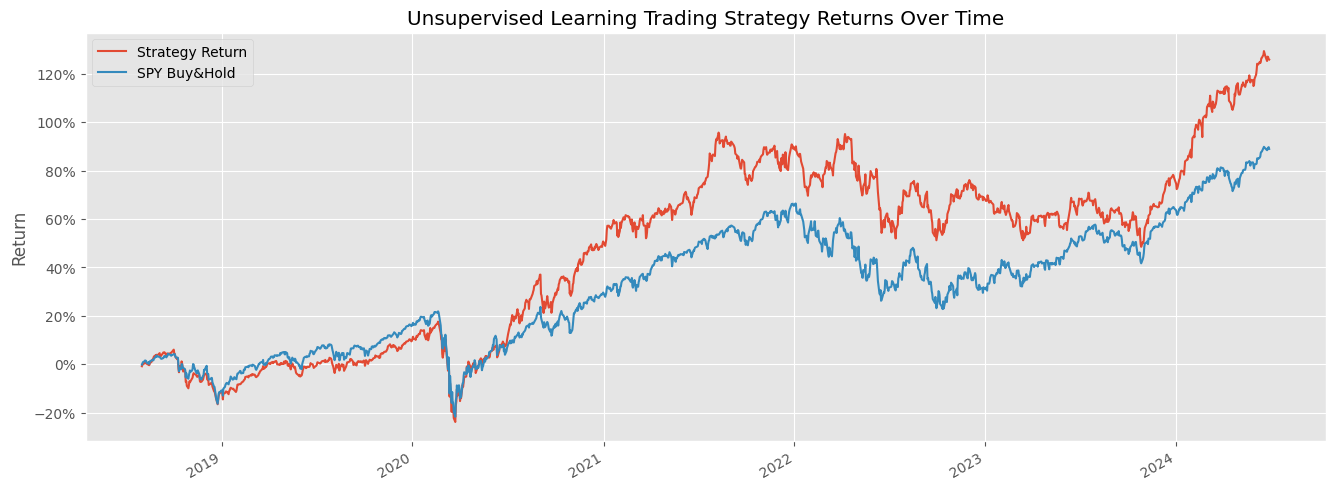

In [127]:
import matplotlib.ticker as mtick

plt.style.use('ggplot')

portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1

portfolio_cumulative_return[:'2024-06-28'].plot(figsize=(16,6))

plt.title('Unsupervised Learning Trading Strategy Returns Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()